## Задача проекта: Составить прогноз, закроется ли стартап

In [1]:
# Загрузка библиотек

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy.stats as st
import sklearn
import sklearn.metrics as metrics


In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from scipy.stats import ttest_ind
from phik import report
from phik.report import plot_correlation_matrix

# Ignore UserWarnings from _encoders.py
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
# category=UserWarning, module='sklearn.preprocessing._encoders')


from sklearn.inspection import permutation_importance 

# загружаем метрики
from sklearn.metrics import f1_score, precision_recall_curve 

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# загружаем нужные модели
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier


In [3]:
# Задаем константу RANDOM_STATE 
RANDOM_STATE = 42

### Используемые функции

In [4]:
# Cоздадим функцию для построения гистограммы и ящика с усами 
""" Функция для создания гистограммы и ящика с усами
Принимает имя датафрейма и список столбцов, для которых строятся графики. Выдает графики
"""
def plot_hist_box(df, column):
    fig, (ax_hist, ax_box,) = plt.subplots(ncols = 2, figsize=(15, 5))

    # зададим графики для каждого ax 
    sns.histplot(df, x=column, ax=ax_hist, bins = 20) 
    sns.boxplot(data = df[column], ax=ax_box)

    ax_hist.grid()
    ax_hist.set(xlabel=column) 
    ax_hist.set(ylabel='Количество') 
    ax_hist.set_title('Гистограмма распределения') 
    ax_box.set_title(f'Разброс значений признака \n {column}')

### Загрузим тренировочный датасет и изучим данные

In [5]:
try: df_train_raw = pd.read_csv(
    '/Users/naziaignatenko/Downloads/arkhiv/2024_07_Masterskaya/kaggle_startups_train_28062024.csv'
                      )
except FileNotFoundError:
    print('Файл не найден')
# Выводим первые 5 значений датафрейма
df_train_raw.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [6]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
df_train_raw.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [8]:
df_train_raw.describe(include='object')

,name,category_list,status,country_code,state_code,region,city,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,52516,47014,45753,46157,46157,52516,52516,52516,4917
unique,52515,22105,2,134,300,1036,4477,5402,4603,4305,3008
top,Lunchgate,Software,operating,USA,CA,SF Bay Area,San Francisco,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,47599,29702,10219,6970,2824,2171,450,369,8


#### Два датафрейма, тренировочный и тестовый, отличаются количеством столбцов. В тестовом датафрейме отсутствуют: дата основания и дата закрытия компании, вместо них присутствует признак время жизни компании (в днях).

In [9]:
# Посмотрим долю закрытых и открытых компаний
df_train_raw['status'].value_counts(normalize=True)


status
operating    0.906371
closed       0.093629
Name: proportion, dtype: float64

In [10]:
# Посмотрим долю закрытых и открытых компаний с отсутствующими географическими данными  
df_train_raw[
    df_train_raw['country_code'].isna() & df_train_raw['state_code'].isna() & df_train_raw['region'].
    isna() & df_train_raw['city'].isna()]['status'].value_counts() 

status
operating    4216
closed       1286
Name: count, dtype: int64

In [11]:
4216+1286

5502

In [12]:
52516-47014

5502

In [13]:
# Заменим NaN на 'unknown' в признаках, относящихся к географии, для учета при обработке
condition = df_train_raw[['country_code', 'state_code', 'region', 'city']].isna().any(axis=1)
df_train_raw.loc[condition, ['country_code', 'state_code', 'region', 'city']] = 'unknown'
 

In [14]:
# Посмотрим долю закрытых и открытых компаний с отсутствующими данными по funding_total_usd
df_train_raw[df_train_raw['funding_total_usd'].isna()]['status'].value_counts(normalize=True)

status
operating    0.898202
closed       0.101798
Name: proportion, dtype: float64

df_train_raw[df_train_raw['funding_total_usd'] > 9.0e9]

# Identify the indices of the rows to be deleted
indices_to_delete = df_train_raw[df_train_raw['funding_total_usd'] > 9.0e9].index

# Drop the rows using the identified indices
df_train_raw.drop(indices_to_delete, inplace=True)

# Verify the number of rows after deletion
remaining_rows = df_train_raw.shape[0]

print(f"Number of rows after deleting the specified rows: {remaining_rows}")

In [15]:
df_train_raw = df_train_raw[(df_train_raw['name'] != 'Cambridge Technology Group') &
                           (df_train_raw['name'] != 'Verizon Communications')]
df_train_raw.shape

(52514, 13)

In [16]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52514 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  42445 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       52514 non-null  object 
 5   state_code         52514 non-null  object 
 6   region             52514 non-null  object 
 7   city               52514 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.6+ MB


In [17]:
# Найдем среднее значение в зависимости от величины funding_rounds 
mean_values = df_train_raw.groupby('funding_rounds')['funding_total_usd'].mean()

# Заполним NaN в столбце funding_total_usd соотвествующими средними значениями
df_train_raw['funding_total_usd'] = df_train_raw.apply(
    lambda row: mean_values[row['funding_rounds']] if pd.isna(row['funding_total_usd']) else row['funding_total_usd'],
    axis=1
)
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52514 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52513 non-null  object 
 1   category_list      50049 non-null  object 
 2   funding_total_usd  52514 non-null  float64
 3   status             52514 non-null  object 
 4   country_code       52514 non-null  object 
 5   state_code         52514 non-null  object 
 6   region             52514 non-null  object 
 7   city               52514 non-null  object 
 8   funding_rounds     52514 non-null  int64  
 9   founded_at         52514 non-null  object 
 10  first_funding_at   52514 non-null  object 
 11  last_funding_at    52514 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.6+ MB


### Загружаем тестовый датасет и изучим данные

In [18]:
try: df_test = pd.read_csv(
    '/Users/naziaignatenko/Downloads/arkhiv/2024_07_Masterskaya/kaggle_startups_test_28062024.csv'
                      )
except FileNotFoundError:
    print('Файл не найден')
# Выводим первые 5 значений датафрейма
df_test.head(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [20]:
df_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


In [21]:
df_train_raw.describe(include='object')

,name,category_list,status,country_code,state_code,region,city,founded_at,first_funding_at,last_funding_at,closed_at
count,52513,50049,52514,52514,52514,52514,52514,52514,52514,52514,4917
unique,52513,22103,2,114,296,1010,4434,5401,4603,4305,3008
top,Lunchgate,Software,operating,USA,CA,unknown,unknown,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,47597,29612,10218,6996,6996,2171,450,369,8


In [22]:
# Заменим NaN на 'unknown' в признаках, относящихся к географии, для учета при обработке
condition = df_test[['country_code', 'state_code', 'region', 'city']].isna().any(axis=1)
df_test.loc[condition, ['country_code', 'state_code', 'region', 'city']] = 'unknown'

In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


### Создадим библиотеку списка категорий, которую классифицируем по ключам - областям деятельности

In [24]:
# Создадим 7 отдельных словарей с одинаковыми ключами (боласти деятельности) для списков категорий
# (для простоты ручного разбиения)
dict_1 = {
    'Information Technology and Cybersecurity': [
        'Technology', 'Information Technology', 'Cloud Computing', 'Cloud Security', 
        'Cyber Security', 'Information Security', 'Developer Tools', 'Software', 
        'Enterprise Software', 'Web Hosting', 'Computers', 'Infrastructure'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Biotechnology', 'Health Care', 'Medical', 'Pharmaceuticals', 'Life Sciences', 
        'Healthcare Services', 'Health and Wellness', 'Physicians'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Manufacturing', 'Nanotechnology', 'Engineering Firms'
    ],
    'Entertainment, Media, and Advertising': [
        'Entertainment', 'Media', 'Film', 'Music', 'Broadcasting', 'Digital Media', 
        'Advertising', 'Advertising Exchanges', 'Ad Targeting', 'Games', 'Content', 
        'Audio', 'Event Management', 'Events', 'Sports'
    ],
    'Science and Scientific Research': [
        'Advanced Materials', 'Geospatial'
    ],
    'Consumer Goods and Services': [
        'Consumers', 'Consumer Goods', 'Consumer Electronics', 'Eyewear', 'Fashion', 
        'Babies', 'Home Decor', 'Beauty', 'Organic Food', 'Coupons'
    ],
    'Energy and Clean Technologies': [
        'Clean Technology', 'Energy'
    ],
    'Transportation, Logistics, and Automotive': [
        'Automotive', 'Transportation', 'Auto', 'Bicycles'
    ],
    'Construction, Real Estate, and Architecture': [
        'Architecture', 'Real Estate'
    ],
    'Tourism and Hospitality': [
        'Adventure Travel', 'Travel', 'Hospitality', 'Online Reservations', 'Restaurants'
    ],
    'Health and Wellness': [
        'Fitness'
    ],
    'Internet Services and Platforms': [
        'Internet', 'Social Network Media', 'E-Commerce', 'Online Shopping', 'Polling', 
        'Marketplaces'
    ],
    'Marketing, Sales, and CRM': [
        'Customer Service', 'Direct Sales', 'Marketing Automation', 'Brand Marketing', 
        'Consulting', 'Auctions', 'Ad Targeting'
    ],
    'Home Technology and Personal Use': [
        'Home Owners', 'DIY'
    ],
    'Materials and New Materials': [
        'Advanced Materials'
    ],
    'Communications and Networking Technologies': [
        'Messaging', 'Chat', 'Communications Hardware'
    ],
    'Innovation and Product Development': [
        'SaaS', 'Augmented Reality', '3D Printing', 'Data Visualization'
    ],
    'Business Services and Support': [
        'Business Services', 'Services', 'Consulting', 'Accounting', 'College Recruiting', 
        'Service Providers', 'Local Businesses', 'Enterprises', 'Business Development'
    ],
    'Software and Development': [
        'Developer Tools', 'Enterprise Software', 'Application Platforms', 'Apps'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Analytics', 'Big Data Analytics', 'Big Data', 'Artificial Intelligence', 
        'Data Visualization'
    ],
    'Medical Technologies and Devices': [
        'Medical Technologies and Devices', 'Medical'
    ],
    'Financial and Banking Services': [
        'Banking', 'Finance', 'Finance Technology', 'Accounting'
    ],
    'Education and Training': [
        'Education', 'College Recruiting', 'All Students', 'Alumni'
    ]
    
}

dict_2 = {
    'Information Technology and Cybersecurity': [
        'IT and Cybersecurity', 'Network Security', 'Networking', 'IT Management', 
        'Identity', 'Data Centers', 'Security', 'Cloud Data Services', 'Computer Vision', 
        'Telecommunications', 'Communications Infrastructure', 'Internet Service Providers'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Health Care Information Technology', 'Health Diagnostics', 'Electronic Health Records', 
        'Medical Devices', 'Bioinformatics', 'Diagnostics', 'Hospitals', 'Therapeutics'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Semiconductor Manufacturing Equipment', 'Industrial', 'Aerospace', 'Defense', 
        'Construction'
    ],
    'Entertainment, Media, and Advertising': [
        'Digital Entertainment', 'News', 'Social Media', 'Digital Signage', 'Journalism', 
        'Blogging Platforms', 'Concerts', 'Comics', 'Creative Industries', 'Content Creators', 
        'Public Relations', 'Video Games', 'Photography'
    ],
    'Science and Scientific Research': [
        'Algorithms', 'Bioinformatics', 'Chemicals'
    ],
    'Consumer Goods and Services': [
        'Cosmetics', 'Specialty Foods', 'Coffee', 'Tea', 'Casual Games', 'Pets', 
        'Home Automation'
    ],
    'Energy and Clean Technologies': [
        'Clean Energy', 'Energy Efficiency', 'Water Purification'
    ],
    'Transportation, Logistics, and Automotive': [
        'Delivery', 'Logistics', 'Public Transportation', 'Online Rental'
    ],
    'Construction, Real Estate, and Architecture': [
        'Construction'
    ],
    'Tourism and Hospitality': [
        'Online Travel', 'Travel & Tourism'
    ],
    'Health and Wellness': [
        'Active Lifestyle', 'Health and Insurance', 'Organic'
    ],
    'Internet Services and Platforms': [
        'E-Commerce Platforms', 'Social Commerce', 'Search', 'Local Search', 'Local Based Services', 
        'Local Based Services', 'Q&A'
    ],
    'Marketing, Sales, and CRM': [
        'Email Marketing', 'Customer Support Tools', 'Direct Marketing', 'SEO', 
        'App Marketing', 'Email'
    ],
    'Home Technology and Personal Use': [
        'Home Automation'
    ],
    'Materials and New Materials': [
        'Chemicals'
    ],
    'Communications and Networking Technologies': [
        'Networking', 'Network Security', 'Wireless', 'Telecommunications'
    ],
    'Innovation and Product Development': [
        'Product Development Services', 'Innovation Management', 'Development Platforms'
    ],
    'Business Services and Support': [
        'Financial Services', 'Credit Cards', 'Billing', 'Professional Networking', 'Career Management', 
        'Document Management', 'Business Productivity', 'Creative', 'Business Intelligence', 
        'Market Research', 'Reviews and Recommendations', 'Nonprofits', 'Consulting', 
        'Human Resources', 'Employment', 'Crowdfunding', 'Startups'
    ],
    'Software and Development': [
        'Development Platforms', 'iOS', 'iPhone', 'Mobile Software Tools'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Databases', 'Data Mining', 'Data Center Automation'
    ],
    'Medical Technologies and Devices': [
        'Medical Devices', 'Diagnostics'
    ],
    'Financial and Banking Services': [
        'Financial Services', 'Credit Cards', 'Bitcoin', 'Payments', 'Credit'
    ],
    'Education and Training': [
        'Guides'
    ]
}


dict_3 = {
    'Information Technology and Cybersecurity': [
        'Information Services', 'Data Security', 'Data Privacy', 'File Sharing'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Dental', 'Nutrition', 'Clinical Trials', 'Alternative Medicine', 'Bio-Pharm'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Innovation Engineering', 'Industrial Automation', 'Embedded Hardware and Software'
    ],
    'Entertainment, Media, and Advertising': [
        'Film Production', 'Content Discovery', 'Social News', 'Celebrity', 'Advertising Platforms', 
        'Mobile Video', 'Internet Marketing', 'Social Media Marketing', 'Video on Demand', 
        'Cloud-Based Music', 'FreetoPlay Gaming'
    ],
    'Science and Scientific Research': [
        'Machine Learning', 'Intelligent Systems', 'Simulation', 'Image Recognition', 
        'Environmental Innovation', 'Mining Technologies'
    ],
    'Consumer Goods and Services': [
        'Lifestyle Products', 'Cooking', 'Jewelry', 'Musical Instruments', 'Furniture', 
        'Shoes', 'Home & Garden', 'Wine And Spirits', 'Custom Retail', 'Gadget'
    ],
    'Energy and Clean Technologies': [
        'Oil', 'Gas', 'Solar', 'Energy Management', 'Oil & Gas', 'Oil and Gas'
    ],
    'Transportation, Logistics, and Automotive': [
        'Logistics Company', 'Fleet Management', 'Cars'
    ],
    'Construction, Real Estate, and Architecture': [
        'Commercial Real Estate', 'Property Management'
    ],
    'Tourism and Hospitality': [
        'Hotels'
    ],
    'Health and Wellness': [
        'Alternative Medicine'
    ],
    'Internet Services and Platforms': [
        'Content Syndication', 'Photo Sharing', 'App Stores', 'Web Development', 
        'Publishing', 'P2P Money Transfer'
    ],
    'Marketing, Sales, and CRM': [
        'CRM', 'Lead Management', 'Contact Management', 'Social CRM', 'Incentives', 
        'Discounts', 'Advertising Platforms'
    ],
    'Home Technology and Personal Use': [
        'Home & Garden'
    ],
    'Materials and New Materials': [
        'Batteries', 'Flash Storage'
    ],
    'Communications and Networking Technologies': [
        'Optical Communications', 'RFID', 'M2M'
    ],
    'Innovation and Product Development': [
        'Product Design', 'Innovation Engineering'
    ],
    'Business Services and Support': [
        'Freelancers', 'Staffing Firms', 'Service Industries', 'Recruiting', 
        'Outsourcing', 'Brokers', 'Small and Medium Businesses', 'Employer Benefits Programs', 
        'Business Information Systems', 'Business Analytics', 'Project Management', 
        'Intellectual Asset Management'
    ],
    'Software and Development': [
        'Open Source', 'Web Development', 'Simulation', 'Archiving', 'Cloud Infrastructure'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Business Analytics', 'Data Privacy', 'Data Security'
    ],
    'Medical Technologies and Devices': [
        'Clinical Trials', 'Bio-Pharm'
    ],
    'Financial and Banking Services': [
        'Insurance', 'FinTech', 'P2P Money Transfer', 'Brokers'
    ],
    'Education and Training': [
        'EdTech', 'Educational Games', 'Charter Schools', 'Colleges'
    ]
}


dict_4 = {
    'Information Technology and Cybersecurity': [
        'Cyber', 'Data Integration', 'Identity Management', 'VoIP', 'Cloud Management', 
        'Application Performance Monitoring', 'Enterprise Search', 'Web Tools'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Elder Care', 'Cosmetic Surgery', 'Fertility', 'Doctors', 'Assisted Living', 
        'Assisitive Technology', 'Dietary Supplements'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Drones', 'Sensors', 'Building Products', 'Material Science', 'Mechanical Solutions', 
        'Civil Engineers', 'Lasers'
    ],
    'Entertainment, Media, and Advertising': [
        'Fantasy Sports', 'Mobile Advertising', 'Advertising Networks', 'Social Travel', 
        'Mobile Games', 'Gamification', 'Entertainment Industry', 'Online Dating', 'Online Scheduling', 
        'Ticketing', 'Internet Radio Market', 'Contests', 'Gambling', 'Leisure'
    ],
    'Science and Scientific Research': [
        'Material Science', 'Natural Resources', 'Biofuels'
    ],
    'Consumer Goods and Services': [
        'Specialty Retail', 'Groceries', 'Craft Beer', 'Retail Technology', 'Baby Accessories', 
        'Handmade', 'Sporting Goods', 'Taxis', 'Subscription Service', 'Wearables', 
        'Electric Vehicles', 'Swimming', 'Loyalty Programs', 'Mobility'
    ],
    'Energy and Clean Technologies': [
        'Renewable Energies', 'Commercial Solar', 'Carbon'
    ],
    'Transportation, Logistics, and Automotive': [
        'Electric Vehicles', 'Distribution', 'Taxis', 'Mobility'
    ],
    'Construction, Real Estate, and Architecture': [
        'Building Products', 'Home Renovation', 'Electrical Distribution', 'Infrastructure Builders'
    ],
    'Tourism and Hospitality': [
        'Resorts', 'Business Travelers'
    ],
    'Health and Wellness': [
        'Exercise', 'Dietary Supplements'
    ],
    'Internet Services and Platforms': [
        'Consumer Internet', 'Social Recruiting', 'SNS', 'Content Delivery', 'Comparison Shopping', 
        'Price Comparison', 'Online Scheduling', 'Social Fundraising'
    ],
    'Marketing, Sales, and CRM': [
        'Promotional', 'Advertising Networks', 'Mobile Advertising', 'Subscription Service', 
        'Loyalty Programs', 'Gift Card'
    ],
    'Home Technology and Personal Use': [
        'Home Renovation', 'Lighting', 'Wearables'
    ],
    'Materials and New Materials': [
        'Material Science'
    ],
    'Communications and Networking Technologies': [
        'Developer APIs', 'Optimization', 'VoIP'
    ],
    'Innovation and Product Development': [
        'Venture Capital', 'Innovation Engineering', 'Incubators'
    ],
    'Business Services and Support': [
        'Professional Services', 'Corporate Training', 'Coworking', 'Enterprise 2.0', 
        'BPO Services', 'Identity Management', 'Governance', 'Procurement'
    ],
    'Software and Development': [
        'Developer APIs', 'Linux', 'Enterprise Application', 'PaaS', 'Enterprise Resource Planning'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Mobile Analytics', 'Optimization'
    ],
    'Medical Technologies and Devices': [
        'Cosmetic Surgery', 'Assisitive Technology'
    ],
    'Financial and Banking Services': [
        'Consumer Lending', 'Investment Management', 'Peer-to-Peer', 'Personal Finance', 
        'Venture Capital'
    ],
    'Education and Training': [
        'Skill Assessment', 'Training', 'Tutoring', 'Corporate Training', 'Online Education', 
        'Language Learning', 'College Campuses', 'High School Students'
    ]
}


dict_5 = {
    'Information Technology and Cybersecurity': [
        'Clean Technology IT', 'Call Center Automation', 'Enterprise Security', 
        'Mobile Infrastructure', 'Mobile Security', 'Internet Infrastructure', 'Privacy', 
        'Fraud Detection', 'ICT', 'Mobile Devices'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Genetic Testing', 'Diabetes', 'Mobile Health', 'Mobile Emergency&Health', 
        'Adaptive Equipment', 'Health Services Industry'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Textiles', 'Specialty Chemicals', 'Systems', 'Robotics', 'Displays'
    ],
    'Entertainment, Media, and Advertising': [
        'Video', 'Online Gaming', 'Video Streaming', 'Photo Editing', 'Audiobooks', 
        'Music Services', 'Independent Music Labels', 'Music Education', 'Online Video Advertising', 
        'Social Media Advertising'
    ],
    'Science and Scientific Research': [
        'Genetic Testing', 'Renewable Tech', 'Early-Stage Technology'
    ],
    'Consumer Goods and Services': [
        'Parenting', 'Child Care', 'Fruit', 'Shopping', 'Spas', 'Lifestyle Businesses', 
        'Collectibles', 'Gift Exchange', 'Green Consumer Goods', 'Families', 'Interior Design', 
        'Animal Feed', 'Baby Safety'
    ],
    'Energy and Clean Technologies': [
        'Biomass Power Generation', 'Clean Technology IT', 'Fuels', 'Renewable Tech', 
        'Energy Storage', 'Natural Gas Uses', 'Energy IT'
    ],
    'Transportation, Logistics, and Automotive': [
        'Shipping'
    ],
    'Construction, Real Estate, and Architecture': [
        'Office Space'
    ],
    'Tourism and Hospitality': [
        'Tourism'
    ],
    'Health and Wellness': [
        'Corporate Wellness'
    ],
    'Internet Services and Platforms': [
        'Domains', 'Online Identity', 'Private Social Networking', 'Social Media Platforms', 
        'Browser Extensions'
    ],
    'Marketing, Sales, and CRM': [
        'Search Marketing', 'Sales Automation', 'Lead Generation', 'Monetization', 
        'Sales and Marketing'
    ],
    'Home Technology and Personal Use': [
        'Home Technology and Personal Use', 'Indoor Positioning'
    ],
    'Materials and New Materials': [
        'Textiles'
    ],
    'Communications and Networking Technologies': [
        'Group SMS', 'User Interface', 'Human Computer Interaction'
    ],
    'Innovation and Product Development': [
        'New Product Development', 'Disruptive Models', 'Early-Stage Technology', 
        'Productivity Software'
    ],
    'Business Services and Support': [
        'Supply Chain Management', 'Shared Services', 'Distributors', 'Wholesale'
    ],
    'Software and Development': [
        'Call Center Automation', 'Web Design', 'Photo Editing', 'Productivity Software'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Consumer Behavior', 'Interest Graph'
    ],
    'Medical Technologies and Devices': [
        'Mobile Health', 'Adaptive Equipment'
    ],
    'Financial and Banking Services': [
        'Financial Exchanges', 'Hedge Funds'
    ],
    'Education and Training': [
        'K-12 Education', 'High Schools', 'Music Education'
    ]
}

dict_6 = {
    'Information Technology and Cybersecurity': [
        'Predictive Analytics', 'Data Center Infrastructure', 'IaaS', 'Corporate IT', 'Internet Technology', 
        'Deep Information Technology', 'Synchronization', 'Speech Recognition', 'Pervasive Computing'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Medical Professionals', 'Independent Pharmacies', 'mHealth', 'Neuroscience', 'Psychology', 
        'Personal Health'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Heavy Industry', 'Biotechnology and Semiconductor'
    ],
    'Entertainment, Media, and Advertising': [
        'MicroBlogging', 'Opinions', 'Nightlife', 'Music Venues', 'Social Games', 'Social Television', 
        'Edutainment', 'In-Flight Entertainment', 'Film Distribution', 'Video Conferencing', 'Internet TV', 
        'Television'
    ],
    'Science and Scientific Research': [
        'Neuroscience', 'Natural Language Processing', 'Face Recognition'
    ],
    'Consumer Goods and Services': [
        'Flowers', 'Gift Registries', 'Weddings', 'Lingerie', 'Toys', 'Golf Equipment', 'Watch'
    ],
    'Energy and Clean Technologies': [
        'Concentrated Solar Power', 'Smart Grid', 'Air Pollution Control', 'Green', 'Fuel Cells'
    ],
    'Transportation, Logistics, and Automotive': [
        'Parking', 'Postal and Courier Services', 'Limousines', 'Ride Sharing'
    ],
    'Construction, Real Estate, and Architecture': [
        'Plumbers', 'Landscaping', 'Building Owners', 'Realtors', 'Rental Housing'
    ],
    'Tourism and Hospitality': [
        'Recreation', 'Boating Industry', 'Nightlife'
    ],
    'Health and Wellness': [
        'Personal Health', 'Self Development', 'Senior Citizens', 'Baby Boomers', 'Retirement'
    ],
    'Internet Services and Platforms': [
        'Portals', 'Forums', 'Web Browsers', 'Internet TV', 'Micro-Enterprises', 'Product Search', 
        'Group Buying', 'Social Bookmarking'
    ],
    'Marketing, Sales, and CRM': [
        'Local Advertising', 'Performance Marketing', 'Social Media Management', 'Freemium', 
        'Multi-level Marketing', 'Cause Marketing', 'Email Newsletters', 'Productivity', 
        'Contact Centers', 'Point of Sale', 'Sponsorship'
    ],
    'Home Technology and Personal Use': [
        'Landscaping', 'Flowers', 'Gift Registries', 'Lingerie'
    ],
    'Materials and New Materials': [
        'Specialty Chemicals', 'Minerals', 'Gold'
    ],
    'Communications and Networking Technologies': [
        'Group SMS', 'QR Codes', 'SMS'
    ],
    'Innovation and Product Development': [
        'New Product Development', 'Estimation and Quoting', 'New Technologies', 'Mass Customization'
    ],
    'Business Services and Support': [
        'Shared Services', 'Contact Centers', 'Field Support Services', 'Enterprise Hardware', 
        'Enterprise Purchasing', 'Human Resource Automation', 'Registrars', 'Sponsorship', 
        'Impact Investing'
    ],
    'Software and Development': [
        'Meeting Software', 'User Experience Design', 'Task Management', 'Internet Technology'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Predictive Analytics', 'Natural Language Processing', 'Face Recognition'
    ],
    'Medical Technologies and Devices': [
        'mHealth', 'Medical Professionals'
    ],
    'Financial and Banking Services': [
        'Trading', 'Utilities', 'Financial Exchanges', 'Debt Collecting'
    ],
    'Education and Training': [
        'Certification Test', 'Training', 'Skill Gaming', 'Edutainment', 'University Students', 
        'Young Adults', 'Kinect', 'Universities', 'High Schools'
    ]
}

dict_7 = {
    'Information Technology and Cybersecurity': [
        'Semantic Search', 'Virtualization', 'NFC', 'Text Analytics', 'Web CMS', 
        'Trusted Networks', 'Visualization', 'Operating Systems', 'Unified Communications', 
        'Vulnerability Management', 'Virtual Desktop', 'Cloud Gaming', 'Spam Filtering', 
        'Web Presence Management'
    ],
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Nutraceutical', 'Medication Adherence', 'Senior Health', 'Rehabilitation'
    ],
    'Manufacturing, Engineering, and Nanotechnology': [
        'Motors', 'EDA Tools', 'Industrial Energy Efficiency', 'FPGA'
    ],
    'Entertainment, Media, and Advertising': [
        'Video Chat', 'MMO Games', 'Video Editing', 'Podcast', 'Performing Arts', 
        'TV Production', 'Hip Hop', 'Video Game Tournaments', 'Theatre', 'Serious Games'
    ],
    'Science and Scientific Research': [
        'Semantic Web', 'Visualization'
    ],
    'Consumer Goods and Services': [
        'Mens Specific', 'Vacation Rentals', 'Recipes', 'Local Services', 'Local Coupons', 
        'Self Storage', 'Mobile Coupons', 'Guide to Nightlife', 'Nightclubs', 'Skate Wear', 
        'Sunglasses', 'First Aid', 'Timeshares', 'Made in Italy', 'Sailing Community', 
        'Surfing Community', 'Twin-Tip Skis', 'Diving', 'Sunglasses', 'Notebooks'
    ],
    'Energy and Clean Technologies': [
        'GreenTech', 'Green Building', 'Residential Solar', 'Rural Energy', 'Wind', 
        'Industrial Energy Efficiency'
    ],
    'Transportation, Logistics, and Automotive': [
        'Utility Land Vehicles', 'Shipping Broker Industry'
    ],
    'Construction, Real Estate, and Architecture': [
        'Green Building', 'Real Estate Investors'
    ],
    'Tourism and Hospitality': [
        'Vacation Rentals'
    ],
    'Health and Wellness': [
        'Senior Health', 'Medication Adherence', 'Rehabilitation'
    ],
    'Internet Services and Platforms': [
        'Cryptocurrency', 'Virtual Currency', 'Virtual Worlds', 'Social Opinion Platform', 
        'Social Innovation', 'Social Entrepreneurship', 'Social Buying', 'Social Investing', 
        'Social Media Monitoring', 'Social Media Agent', 'Social Media Platforms', 
        'Social Media Advertising', 'Video Processing', 'Mobile Search', 'Social Search', 
        'Prediction Markets', 'Quantified Self', 'User Testing', 'Mobile Enterprise'
    ],
    'Marketing, Sales, and CRM': [
        'Subscription Businesses', 'Freemium', 'Performance Marketing', 'Direct Advertising', 
        'Quantitative Marketing', 'Salesforce Killers', 'Lead Generation', 'Local Advertising'
    ],
    'Home Technology and Personal Use': [
        'Smart Building', 'Reading Apps'
    ],
    'Materials and New Materials': [
        'UV LEDs'
    ],
    'Communications and Networking Technologies': [
        'Telephony', 'Video Chat', 'Unified Communications'
    ],
    'Innovation and Product Development': [
        'New Product Development', 'Radical Breakthrough Startups', 'Invention', 'Early Stage IT'
    ],
    'Business Services and Support': [
        'Franchises', 'Hi Tech', 'Wealth Management', 'Ventures for Good', 'Tech Field Support', 
        'Transaction Processing', 'Temporary Staffing', 'Testing', 'Test and Measurement', 
        'Labor Optimization', 'Consulting Services', 'Private Corrections', 'Subscription Businesses'
    ],
    'Software and Development': [
        'Google Apps', 'Mac', 'PC Gaming', 'Software Compliance', 'Social Media Monitoring', 
        'Video Editing', 'Web CMS', 'Video Processing', 'Testing', 'Test and Measurement', 
        'Labor Optimization', 'Software Development', 'iPod Touch', 'Windows Phone 7', 'WebOS'
    ],
    'Analytics, Big Data, and Artificial Intelligence': [
        'Predictive Analytics', 'Text Analytics', 'Social Search', 'Quantified Self', 
        'Semantic Search', 'Quantitative Marketing', 'Text Analytics', 'Vulnerability Management'
    ],
    'Medical Technologies and Devices': [
        'Nutraceutical', 'Medication Adherence'
    ],
    'Financial and Banking Services': [
        'Insurance Companies', 'Cryptocurrency', 'Virtual Currency', 'Wealth Management'
    ],
    'Education and Training': [
        'Teachers', 'Teaching STEM Concepts', 'Technical Continuing Education', 'Private School'
    ]
}


In [25]:
# Добавим дополнительные словари с такими же ключами
other_1 = {
    'Information Technology and Cybersecurity': [
        'Predictive Analytics', 'Data Center Infrastructure', 'IaaS', 'Internet Technology', 
        'Deep Information Technology', 'Face Recognition', 'Natural Language Processing', 'Synchronization', 
        'Speech Recognition', 'Internet TV', 'Internet Technology', 'Personal Data'
    ],
    
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Independent Pharmacies', 'mHealth', 'Personal Health', 'Biotechnology and Semiconductor', 
        'Neuroscience', 'Psychology'
    ],
    
    'Manufacturing, Engineering, and Nanotechnology': [
        'Heavy Industry', 'Enterprise Hardware', 'Fuel Cells'
    ],
    
    'Entertainment, Media, and Advertising': [
        'Social Games', 'Television', 'In-Flight Entertainment', 'Social Television', 'Edutainment', 
        'Music Venues', 'Film Distribution', 'Skill Gaming', 'Racing'
    ],
    
    'Science and Scientific Research': ['Neuroscience'],
    
    'Consumer Goods and Services': [
        'Rental Housing', 'Flowers', 'Lingerie', 'Toys', 'Golf Equipment', 'Limousines', 'Recreation', 
        'Boating Industry', 'Vending and Concessions', 'Mass Customization', 'Gift Registries'
    ],
    
    'Energy and Clean Technologies': [
        'Concentrated Solar Power', 'Smart Grid', 'Green', 'Air Pollution Control'
    ],
    
    'Transportation, Logistics, and Automotive': [
        'Ride Sharing', 'Parking', 'Postal and Courier Services'
    ],
    
    'Construction, Real Estate, and Architecture': [
        'Building Owners', 'Realtors', 'Landscaping'
    ],
    
    'Tourism and Hospitality': ['Nightlife'],
    
    'Health and Wellness': ['Personal Health', 'Veterinary', 'Senior Citizens', 'Retirement', 'Baby Boomers'],
    
    'Internet Services and Platforms': [
        'Web Browsers', 'Portals', 'Forums', 'App Discovery', 'Social Bookmarking', 'Social Media Management',
        'Social + Mobile + Local'
    ],
    
    'Marketing, Sales, and CRM': ['Local Advertising', 'Performance Marketing', 'Freemium', 'Cause Marketing', 
                                  'Personal Branding', 'Multi-level Marketing', 'Surveys', 'Group Buying',
                                  'Farmers Market'
    ],
    
    'Home Technology and Personal Use': ['Smart Grid', 'Plumbers', 'Utilities', 'Water'],
    
    'Materials and New Materials': ['Minerals'],
    
    'Communications and Networking Technologies': [
        'Video Conferencing', 'SMS'
    ],
    
    'Innovation and Product Development': ['New Technologies'],
    
    'Business Services and Support': [
        'Corporate IT', 'Contact Centers', 'Human Resource Automation', 'Enterprise Purchasing', 
        'Field Support Services', 'Productivity', 'Estimation and Quoting', 'Licensing', 'Intellectual Property',
        'Micro-Enterprises', 'Task Management', 'Impact Investing', 'Sponsorship', 'Social Business', 'Freemium'
    ],
    
    'Software and Development': [
        'Point of Sale', 'Meeting Software', 'User Experience Design', 'Game Mechanics', 'Kinect'
    ],
    
    'Analytics, Big Data, and Artificial Intelligence': [
        'Predictive Analytics', 'Deep Information Technology'
    ],
    
    'Medical Technologies and Devices': [],
    
    'Financial and Banking Services': ['Trading', 'Debt Collecting'],
    
    'Education and Training': [
        'Universities', 'Young Adults', 'Self Development', 'University Students'
    ],
    
    'Other': [
        'Reputation',   'Sex Industry', 'Weddings', 'SexTech',  'Non-Tech', 'Watch', 'Gold' 
    ]
}


other_2 = {
    'Information Technology and Cybersecurity': [
        'Internet of Things', 'Ediscovery', 'Tracking', 'Algorithms', 'Facebook Applications', 
        'Crowdsourcing', 'Social Media Platforms', 'Online Identity', 'Human Computer Interaction', 
        'Indoor Positioning'
    ],
    
    'Biotechnology, Healthcare, and Pharmaceuticals': ['Bioinformatics', 'Cannabis', 'Corporate Wellness'],
    
    'Manufacturing, Engineering, and Nanotechnology': ['Mechanical Solutions', 'Food Processing'],
    
    'Entertainment, Media, and Advertising': [
        'Graphics', 'Independent Music Labels', 'Social Media Advertising', 'Soccer', 'Printing'
    ],
    
    'Science and Scientific Research': ['Space Travel'],
    
    'Consumer Goods and Services': [
        'Pets', 'Online Dating', 'Outdoors', 'Green Consumer Goods', 'Funeral Industry', 'Families'
    ],
    
    'Energy and Clean Technologies': [],
    
    'Transportation, Logistics, and Automotive': ['B2B Express Delivery'],
    
    'Construction, Real Estate, and Architecture': [],
    
    'Tourism and Hospitality': ['Indians', 'Communities', 'Charity', 'Charities', 'Charities', 'Humanitarian',
                               'General Public Worldwide'],
    
    'Health and Wellness': ['Corporate Wellness', 'Community Services', 'Kids', 'Demographies', 'Religion',
                           'Physical Security', 'Advice'],
    
    'Internet Services and Platforms': [
        'Facebook Applications', 'Crowdsourcing', 'Social Media Platforms', 'Online Dating', 
        'Local Commerce', 'Online Education', 'Bridging Online and Offline', 'Maps'
    ],
    
    'Marketing, Sales, and CRM': ['Sales Automation', 'Reviews and Recommendations', 'All Markets',
                                 'Social Fundraising', 'Commodities'],
    
    'Home Technology and Personal Use': [],
    
    'Materials and New Materials': [],
    
    'Communications and Networking Technologies': ['Social Media Platforms', 'Private Social Networking', 
                                                   'China Internet'],
    
    'Innovation and Product Development': ['Disruptive Models'],
    
    'Business Services and Support': [
        'Business Intelligence', 'Ediscovery', 'Legal', 'Procurement', 'Knowledge Management', 
        'Skill Assessment', 'Training', 'Career Planning', 'Freelancers', 'Anything Capital Intensive',
        'Government Innovation', 'Entrepreneur'
    ],
    
    'Software and Development': ['Real Time'],
    
    'Analytics, Big Data, and Artificial Intelligence': ['Business Intelligence', 'Interest Graph'],
    
    'Medical Technologies and Devices': [],
    
    'Financial and Banking Services': ['Mobile Payments', 'Non Profit'],
    
    'Education and Training': ['Online Education', 'Training', 'Skill Assessment', 'Colleges', 'English-Speaking'],
    
    'Other': [
        'Agriculture',  'Defense',  'Law Enforcement', 'DOD/Military', 'Politics', 'Civil Engineers', 
        'Homeland Security', 'Governments',            
    ]
}

other_3 = {
    'Information Technology and Cybersecurity': [
        'Text Analytics', 'Web CMS', 'Tech Field Support', 'Telephony', 'Unified Communications', 
        'Software Compliance', 'Transaction Processing', 'Operating Systems', 'Virtual Desktop', 
        'Vulnerability Management', 'Spam Filtering', 'Proximity Internet', 'Early Stage IT'
    ],
    
    'Biotechnology, Healthcare, and Pharmaceuticals': [
        'Medication Adherence', 'Senior Health', 'Rehabilitation'
    ],
    
    'Manufacturing, Engineering, and Nanotechnology': [
        'EDA Tools', 'FPGA', 'Industrial Energy Efficiency', 'Hi Tech', 'Mac'
    ],
    
    'Entertainment, Media, and Advertising': [
        'Social Media Platforms', 'Video Editing', 'Nightclubs', 'Guide to Nightlife', 'Hip Hop', 
        'TV Production', 'Performing Arts', 'Theatre', 'Social Media Agent', 'Podcast', 
        'Serious Games', 'Sports Stadiums', 'Musicians', 'Writers'
    ],
    
    'Science and Scientific Research': [
        'Teaching STEM Concepts'
    ],
    
    'Consumer Goods and Services': [
        'Vacation Rentals', 'Local Services', 'Local Coupons', 'Self Storage', 'Surfing Community', 
        'Skate Wear', 'Sunglasses', 'Twin-Tip Skis', 'Textbooks', 'Sunglasses', 'iPod Touch', 
        'PC Gaming', 'Notebooks', 'FMCG', 'Mothers', 'HDTV', 'Skate Wear', 'Teenagers'
    ],
    
    'Energy and Clean Technologies': [
        'GreenTech', 'Green Building', 'Wind', 'Rural Energy', 'Residential Solar', 'Remediation'
    ],
    
    'Transportation, Logistics, and Automotive': [
        'Motors', 'Utility Land Vehicles', 'Shipping Broker Industry'
    ],
    
    'Construction, Real Estate, and Architecture': ['Real Estate Investors', 'Green Building', 'Smart Building'
    ],
    
    'Tourism and Hospitality': [
        'Vacation Rentals', 'Guide to Nightlife', 'West Africa','South East Asia', 'Diving', 'East Africa',
        'Hunting Industry', 'Twin-Tip Skis'
    ],
    
    'Health and Wellness': [
        'Medication Adherence', 'Senior Health', 'Rehabilitation', 'First Aid', 'Quantified Self',
        'Private Corrections', 'Elderly', 'Recipes', 'Underserved Children', 'Social Activists',
        'Quantified Self'
    ],
    
    'Internet Services and Platforms': [
        'Google Apps', 'Web CMS', 'Semantic Web', 'Social Media Platforms', 'Social Search', 
        'Mobile Search', 'Mobile Shopping', 'Online Auctions', 'Social Buying', 'Social Investing', 
        'Social Entrepreneurship', 'Web Presence Management', 'Vertical Search', 'Social Media Monitoring'
    ],
    
    'Marketing, Sales, and CRM': [
        'Local Coupons', 'Direct Advertising', 'Outdoor Advertising', 'Quantitative Marketing',
        'Made in Italy', 'Niche Specific', 'Startup Histrionics', 'Experience Design'
    ],
    
    'Home Technology and Personal Use': [
        'Smart Building', 'Google Apps', 'iPod Touch', 'Reading Apps', 'WebOS'
    ],
    
    'Materials and New Materials': ['UV LEDs'],
    
    'Communications and Networking Technologies': [
        'Telephony', 'Unified Communications', 'Trusted Networks'
    ],
    
    'Innovation and Product Development': [
        'Invention', 'Radical Breakthrough Startups', 'Ventures for Good'
    ],
    
    'Business Services and Support': [
        'Temporary Staffing', 'Labor Optimization', 'Test and Measurement', 'Transaction Processing', 
        'Web Presence Management', 'Software Compliance', 'User Testing', 'Timeshares', 'Direct Advertising',
        'Offline Businesses', 'Social Investing'
    ],
    
    'Software and Development': [
        'Testing', 'Video Processing', 'WebOS', 'Cloud Gaming', 'Salesforce Killers', 'App Discovery',
        'Visual Search', 'Usability', 'Windows Phone 7', 'Visualization', 'Virtual Goods', 'Reading Apps',
        'Motion Capture', 'Graphic Design'
    ],
    
    'Analytics, Big Data, and Artificial Intelligence': [
        'Text Analytics', 'Visual Search', 'Prediction Markets'
    ],
    
    'Medical Technologies and Devices': ['Medication Adherence'],
    
    'Financial and Banking Services': ['Wealth Management'],
    
    'Education and Training': [
        'Teachers', 'Teaching STEM Concepts', 'Private School', 'Technical Continuing Education'
    ],
    
    'Other': ['Sustainability', 'RIM', 'unknown'         
    ],
    'unknown': [''],
    'empty': []
}

other_4 = {
    'Information Technology and Cybersecurity': ['Biometrics', 'Public Safety', 'Unifed Communications'],
    
    'Biotechnology, Healthcare, and Pharmaceuticals': ['Aquaculture'],
    
    'Manufacturing, Engineering, and Nanotechnology': ['3D Technology', '3D', 'Unmanned Air Systems', 
                                                       'Semiconductors', 
                                                       'Hardware', 'High Tech', 'Electronics'],
    
    'Entertainment, Media, and Advertising': ['Independent Music', 'TV Station', 'Art', 
                                              'Artists Globally', 'EBooks', 'E-Books', 'Cable', 'Console Gaming',
                                              'Game'],
    
    'Science and Scientific Research': ['Farming'],
    
    'Consumer Goods and Services': ['Flash Sales', 'Low Bid Auctions', 'Retail', 'Lotteries', 'Fmcg', 'Brewing',
                                   'Collaborative Consumption'],
    
    'Energy and Clean Technologies': ['Recycling', 'Waste Management'],
    
    'Transportation, Logistics, and Automotive': ['Gps', 'Navigation'],
    
    'Construction, Real Estate, and Architecture': ['CAD'],
    
    'Tourism and Hospitality': ['Local', 'Match-Making'],
    
    'Health and Wellness': ['Lifestyle', 'Women', 'Generation Y-Z'],
    
    'Internet Services and Platforms': ['Classifieds', 'Curated Web'],
    
    'Marketing, Sales, and CRM': ['Rapidly Expanding', 'Digital Rights Management', 'Stock Exchanges', 'B2B'],
    
    'Home Technology and Personal Use': ['Google Glass', 'iPad', 'Tablets'],
    
    'Materials and New Materials': [],
    
    'Communications and Networking Technologies': ['Unified Communications', 'Mobile Social', 'Mobile Commerce', 
                                                   'Mobile', 'Twitter Applications'],
    
    'Innovation and Product Development': ['Interface Design', 'Designers', 'Design'],
    
    'Business Services and Support': ['Virtual Workforces', 'Translation', 'Collaboration', 'Pre Seed', 
                                      'Risk Management', 'Presentations', 'Emerging Markets', 'Automated Kiosk',
                                      'Location Based Services', 'Angels'
                                     ],
    'Software and Development': ['Hardware + Software', 'Android'],
    
    'Analytics, Big Data, and Artificial Intelligence': ['Storage', 'Personalization'],
    
    'Medical Technologies and Devices': [],
    
    'Financial and Banking Services': ['Moneymaking'],
    
    'Education and Training': [],
    
    
}

In [26]:
# Создадим функцию для объяединения словарей
def merge_dictionaries(*dicts):
    merged_dict = {}
    for d in dicts:
        for key, value in d.items():
            if key in merged_dict:
                merged_dict[key].extend(value)  # Удлиняем список существующих ключей
            else:
                merged_dict[key] = list(value)  # Создаем список несуществующих ключей
    return merged_dict

# Объединим словари в один
dict_sum = merge_dictionaries(dict_1, dict_2, dict_3, dict_4, dict_5, dict_6, dict_7, 
                              other_1, other_2, other_3, other_4)



### Посмотрим на форму датафреймов

In [27]:
print(df_train_raw.shape)

(52514, 13)


In [28]:
print(df_test.shape)

(13125, 11)


In [29]:
print(df_train_raw.columns)

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')


In [30]:
print(df_test.columns)

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')


#### Два датафрейма, тренировочный и тестовый, отличаются количеством столбцов. В тестовом датафрейме отсутствуют: дата основания и дата закрытия компании, вместо них присутствует признак время жизни компании (в днях).

### Конвертируем признаки даты из object в datatime в тренировочной и тестовой выборках

# Конвертируем в тренировочной выборке

date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for col in date_columns:
    df_train_raw[col] = pd.to_datetime(df_train_raw[col], format='%Y-%m-%d', errors='coerce')

# Конвертируем в тестовой выборке

date_columns = ['first_funding_at', 'last_funding_at']
for col in date_columns:
    df_test[col] = pd.to_datetime(df_test[col], format='%Y-%m-%d', errors='coerce')

#### В датафрейме с тестовыми данными так же в основном присутствуют данные типа object (8 столбцов), и только три числовых столбца: funding_total_usd (float64), funding_rounds (int64) и lifetime (int64). В столбце category_list, который относится к области деятельности компании - 6206 уникальных значений, где Software, также встречается наиболее часто. 

### Добавление новых признаков в тренировочную выборку

In [31]:
# Добавим время жизни компании в тренировочный датафрейм. 

# Заполняем NaN датой извлечения данных
df_train_raw.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True) 

# Вычислим время жизни компании, путем вычитания из даты закрытия даты основания компании, 
# с переводом типа object в datetime, а результат трансформируем в дни

df_train_raw[df_train_raw.closed_at.astype("datetime64[ns]") == df_train_raw.founded_at.astype("datetime64[ns]")]


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [32]:
df_train_raw['lifetime'] = (
    abs(df_train_raw.closed_at.astype("datetime64[ns]")-df_train_raw.founded_at.astype("datetime64[ns]"))).dt.days


In [33]:
df_train_raw['lifetime_year'] = df_train_raw['lifetime']/365.25
df_train_raw.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,lifetime_year
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01 00:00:00,2998,8.208077
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01 00:00:00,4748,12.999316
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01 00:00:00,4383,12.000000
3,Sancilio and Company,Health Care,2.225000e+07,operating,unknown,unknown,unknown,unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01 00:00:00,5114,14.001369
4,WireTough Cylinders,Manufacturing,8.863725e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01 00:00:00,2791,7.641342


In [34]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_train_raw['log_funding_total_usd'] = np.log1p(df_train_raw['funding_total_usd'])

In [35]:
df_train_raw['funding_period'] = (
    abs(df_train_raw.last_funding_at.astype("datetime64[ns]") - df_train_raw.first_funding_at.astype("datetime64[ns]"))
    ).dt.days

In [36]:
df_train_raw[df_train_raw['funding_period'] == 0].shape

(33705, 17)

In [37]:
df_train_raw['funding_rounds_per_year'] = df_train_raw['funding_rounds'] / df_train_raw['lifetime_year']
df_train_raw['funding_total_per_year'] = df_train_raw['funding_total_usd'] / df_train_raw['lifetime_year']
df_train_raw['funding_per_round'] = df_train_raw['funding_total_usd'] / df_train_raw['funding_rounds']
#df_train_raw['funding_rounds_duration_ratio'] = df_train_raw['funding_period'] / df_train_raw['lifetime_year']
df_train_raw['funding_sum_lifetime_ratio'] = df_train_raw['funding_total_usd'] / df_train_raw['lifetime_year']

df_train_raw['log_funding_total_year'] = df_train_raw['log_funding_total_usd'] / df_train_raw['lifetime_year']
df_train_raw['log_funding_per_round'] = df_train_raw['log_funding_total_usd'] / df_train_raw['funding_rounds']
#df_train_raw['funding_rounds_duration_ratio'] = df_train_raw['funding_period'] / df_train_raw['lifetime_year']
df_train_raw['log_funding_lifetime_ratio'] = df_train_raw['log_funding_total_usd'] / df_train_raw['lifetime_year']

# Handle infinite values resulting from division by zero
df_train_raw.replace([float('inf'), -float('inf')], 0, inplace=True)

In [38]:
# Введем признак количество категорий, где за единицу примем категорию до знака разделения '|'

df_train_raw['categories_number'] = df_train_raw['category_list'].apply(
                lambda x: x.count('|') + 1 if isinstance(x, str) else 0)
df_train_raw.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,log_funding_total_usd,funding_period,funding_rounds_per_year,funding_total_per_year,funding_per_round,funding_sum_lifetime_ratio,log_funding_total_year,log_funding_per_round,log_funding_lifetime_ratio,categories_number
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,13.627525,1310,0.243662,1.009525e+05,4.143130e+05,1.009525e+05,1.660258,6.813763,1.660258,2
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,17.575198,1393,0.307709,3.302868e+06,1.073375e+07,3.302868e+06,1.352010,4.393800,1.352010,3
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,17.383814,681,0.250000,2.954698e+06,1.181879e+07,2.954698e+06,1.448651,5.794605,1.448651,1
3,Sancilio and Company,Health Care,2.225000e+07,operating,unknown,unknown,unknown,unknown,3,2004-01-01,...,16.917853,1051,0.214265,1.589130e+06,7.416667e+06,1.589130e+06,1.208300,5.639284,1.208300,1
4,WireTough Cylinders,Manufacturing,8.863725e+06,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,15.997478,0,0.130867,1.159970e+06,8.863725e+06,1.159970e+06,2.093543,15.997478,2.093543,1


In [39]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_train_raw['log_funding_total_usd'] = np.log1p(df_train_raw['funding_total_usd'])

#### Категоризация признака список_категорий

In [40]:
# Посмотрим как распределены компании по количеству заявленных категорий
cat_number = df_train_raw['categories_number'].value_counts(normalize = True).head(41)
cat_number_sorted = cat_number.sort_index()
cat_number_sorted

categories_number
0     0.046940
1     0.449252
2     0.118426
3     0.184084
4     0.094756
5     0.042827
6     0.027098
7     0.014967
8     0.009198
9     0.005084
10    0.003371
11    0.001523
12    0.000990
13    0.000438
14    0.000305
15    0.000324
16    0.000076
17    0.000057
18    0.000076
19    0.000057
20    0.000019
22    0.000019
23    0.000076
25    0.000019
40    0.000019
Name: proportion, dtype: float64

In [41]:
# Посчитаем нарастающую долю признаков
sum = 0
for i, value in cat_number_sorted.items():
    sum = sum + value
    print(i, round(sum, 3))

0 0.047
1 0.496
2 0.615
3 0.799
4 0.893
5 0.936
6 0.963
7 0.978
8 0.988
9 0.993
10 0.996
11 0.998
12 0.999
13 0.999
14 0.999
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
22 1.0
23 1.0
25 1.0
40 1.0


Исходя из полученных данных, создадим 6 столбцов, в которые внесем первые 5 категорий каждой компании, если категорий меньше, заполним пустиыми значниями

In [42]:
# Создадим функцию, которая позволит в разделить названия в каждой строке столбца category_list 
# на отдельные области деятельности и разместить их в отдельные созданные столбцы
def split_and_pad(s):
    # Проверяем, является ли s строкой
    if isinstance(s, str):
        fields = s.split('|')
        padded_fields = fields[:5]
    else:
        # Если s не строка (например, NaN), возвращаем список с пустыми строками
        padded_fields = [''] * 5
    return padded_fields

# Применяем функцию к столбцу и создаем новый DataFrame
new_columns = df_train_raw['category_list'].apply(split_and_pad).tolist()
new_df = pd.DataFrame(new_columns, columns=[f'Field_{i+1}' for i in range(5)])

# Добавляем новые столбцы в исходный DataFrame
df_train_concat = pd.concat([df_train_raw, new_df], axis=1)
# df_train_raw['category_list'].isna().sum()
df_train_concat.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,funding_sum_lifetime_ratio,log_funding_total_year,log_funding_per_round,log_funding_lifetime_ratio,categories_number,Field_1,Field_2,Field_3,Field_4,Field_5
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2.0,2009-10-17,...,1.009525e+05,1.660258,6.813763,1.660258,2.0,Online Reservations,Restaurants,None,None,None
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4.0,2005-01-01,...,3.302868e+06,1.352010,4.393800,1.352010,3.0,Manufacturing,Medical,Medical Devices,None,None
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3.0,2006-01-01,...,2.954698e+06,1.448651,5.794605,1.448651,1.0,Biotechnology,None,None,None,None
3,Sancilio and Company,Health Care,2.225000e+07,operating,unknown,unknown,unknown,unknown,3.0,2004-01-01,...,1.589130e+06,1.208300,5.639284,1.208300,1.0,Health Care,None,None,None,None
4,WireTough Cylinders,Manufacturing,8.863725e+06,operating,USA,VA,VA - Other,Bristol,1.0,2010-05-12,...,1.159970e+06,2.093543,15.997478,2.093543,1.0,Manufacturing,None,None,None,None


In [43]:
# Категории в полученных столбцах заменим ключами (областями деятельности) 
# Поскольку возможны дубликаты в списках, оставим первую встечающуюся категорию, а дубликаты сотрем
reverse_dict = {}
for k, values in dict_sum.items():
    for v in values:
        if v not in reverse_dict:
            reverse_dict[v] = k

# Заменим категории на ключи словаря
columns_to_replace = ['Field_1', 'Field_2', 'Field_3', 'Field_4', 'Field_5']
df_train = df_train_concat

# Применим функцию обработки значений None и отсутствующих строк (в качестве защиты)
df_train[columns_to_replace] = df_train[columns_to_replace].applymap(
                                        lambda x: reverse_dict.get(x, "unknown") if x is not None else 'empty')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, 0 to 39186
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        52513 non-null  object 
 1   category_list               50049 non-null  object 
 2   funding_total_usd           52514 non-null  float64
 3   status                      52514 non-null  object 
 4   country_code                52514 non-null  object 
 5   state_code                  52514 non-null  object 
 6   region                      52514 non-null  object 
 7   city                        52514 non-null  object 
 8   funding_rounds              52514 non-null  float64
 9   founded_at                  52514 non-null  object 
 10  first_funding_at            52514 non-null  object 
 11  last_funding_at             52514 non-null  object 
 12  closed_at                   52514 non-null  object 
 13  lifetime                    52514 no

In [44]:
df_train = df_train[(~df_train['name'].isna())]
df_train.shape

(52513, 30)

### Анализ признаков в тренировочном датафрейме

In [45]:
### Посмотрим, сколько компаний закрылось в тренировочной выборке
df_train['status'].value_counts()

status
operating    47597
closed        4916
Name: count, dtype: int64

In [46]:
df_train['status'].value_counts(normalize=True)

status
operating    0.906385
closed       0.093615
Name: proportion, dtype: float64

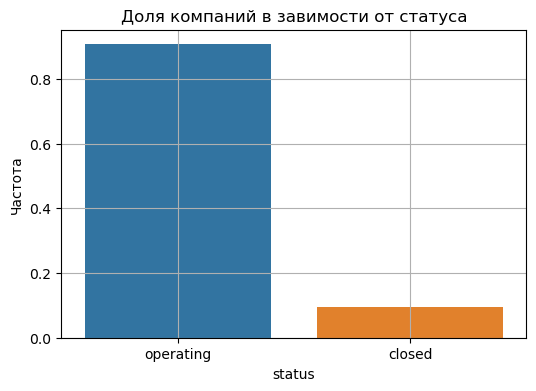

In [47]:
status_counts = df_train['status'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Доля компаний в завимости от статуса')
plt.ylabel('Частота')
plt.grid()
plt.show()


#### Выборка сильно несбалансированная, работающих компаний - 90%, и только 10% закрытых.

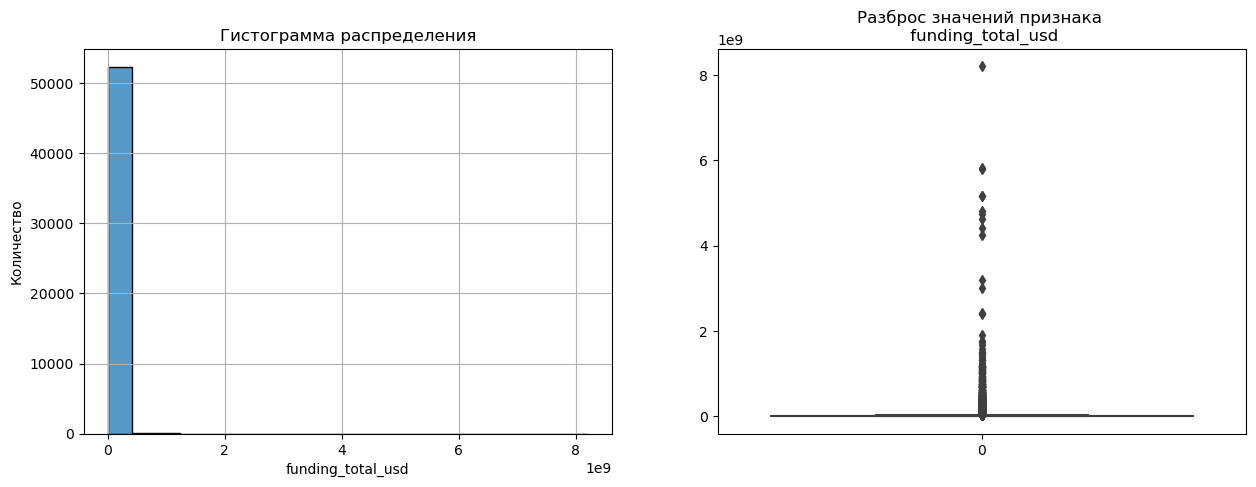

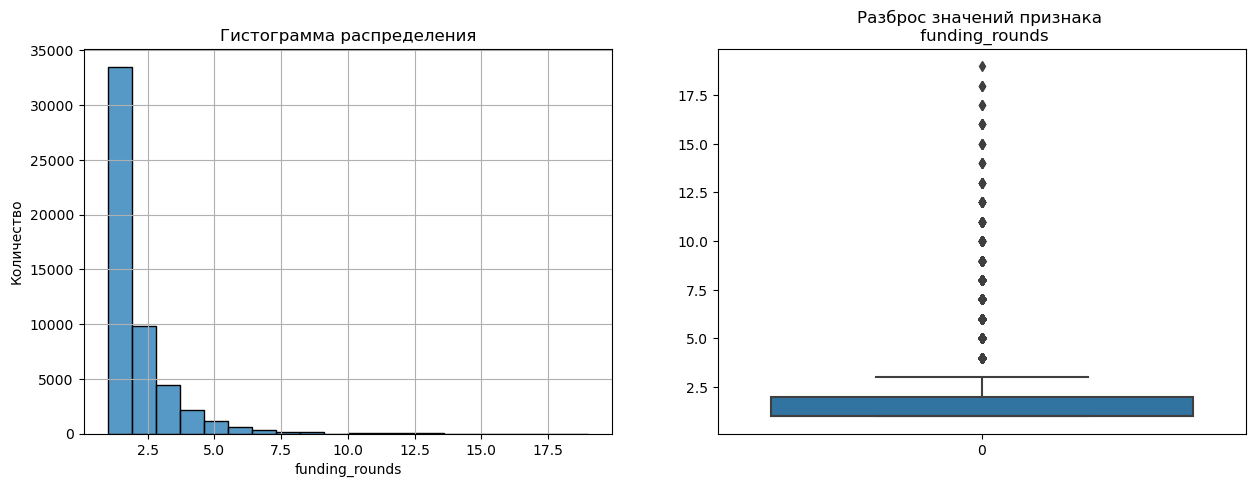

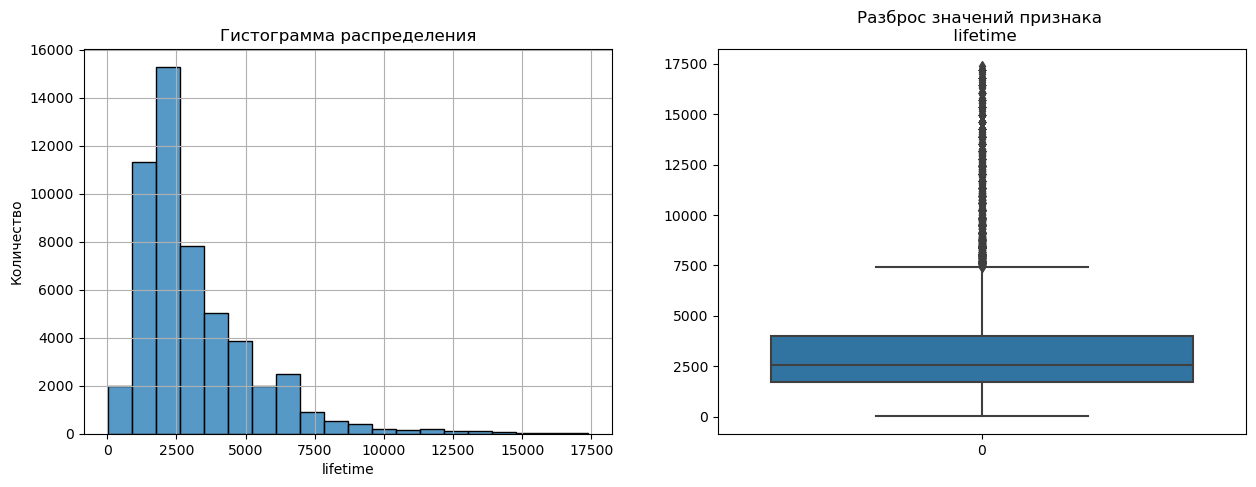

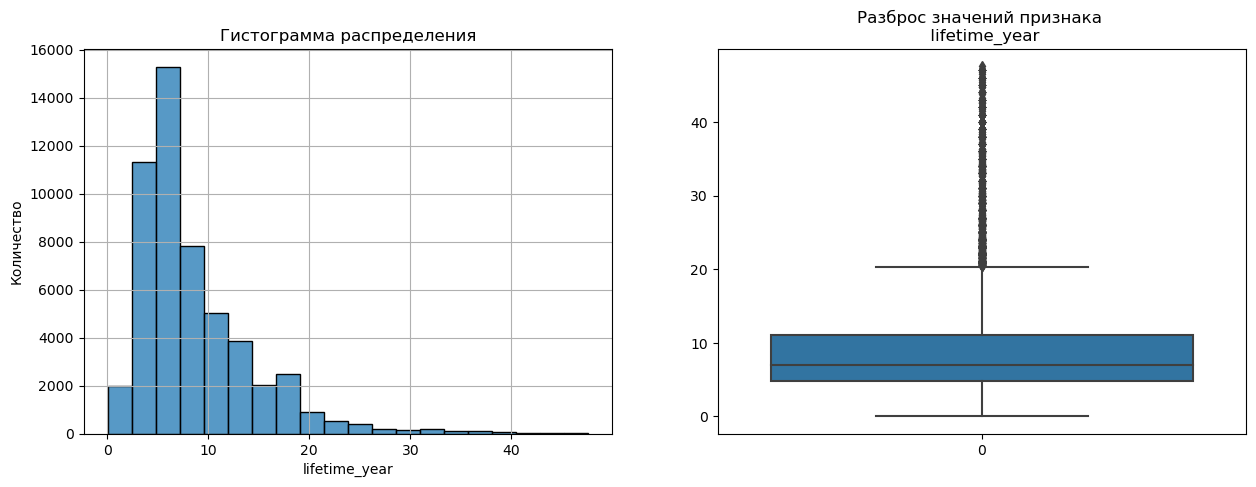

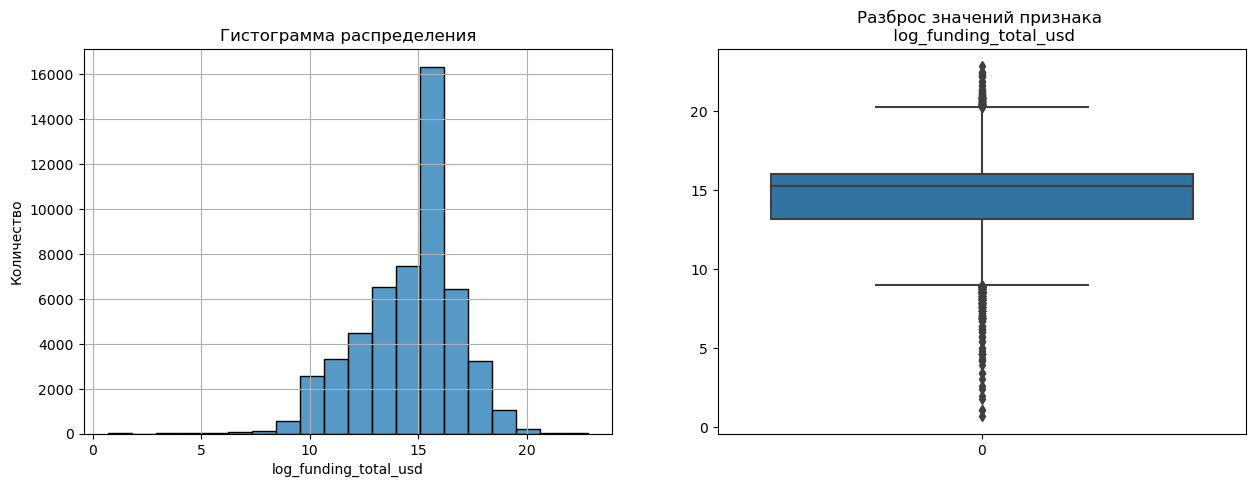

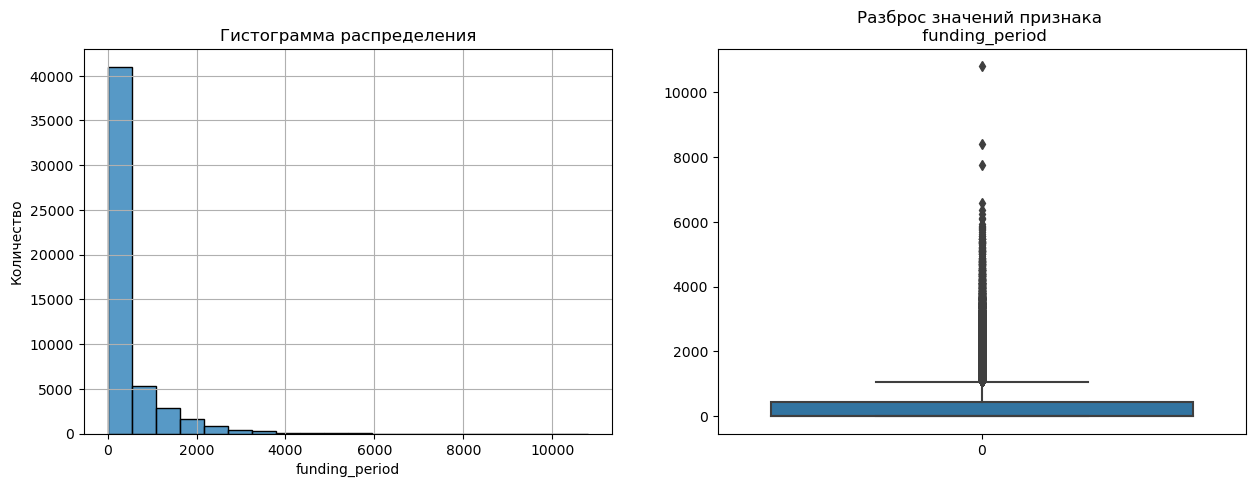

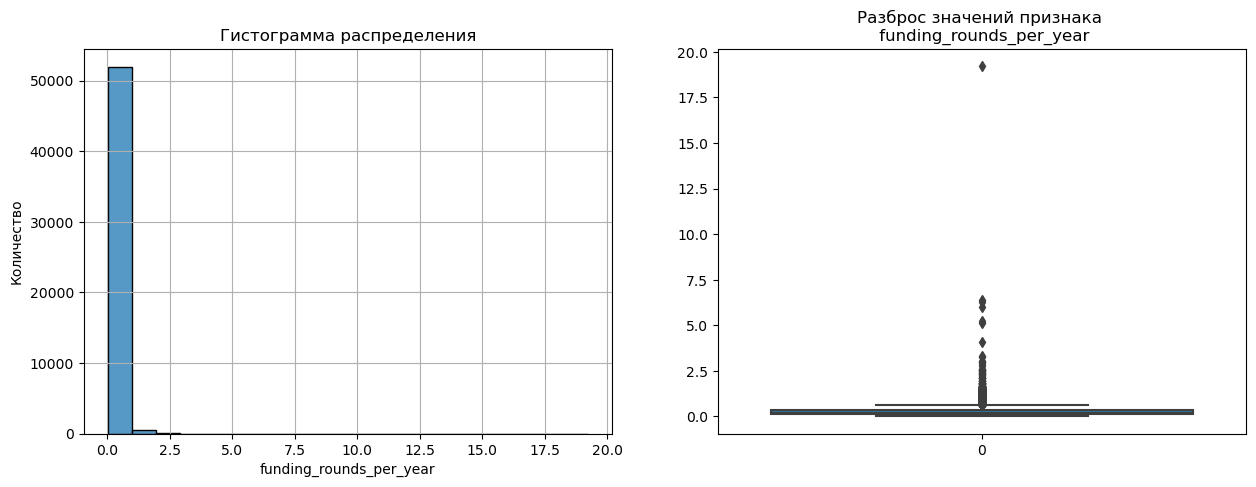

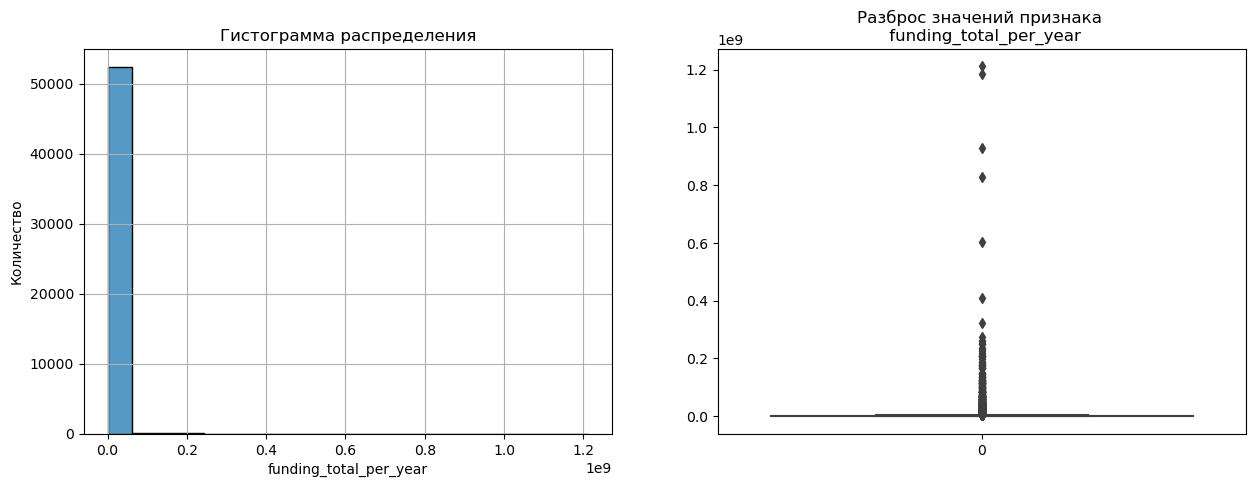

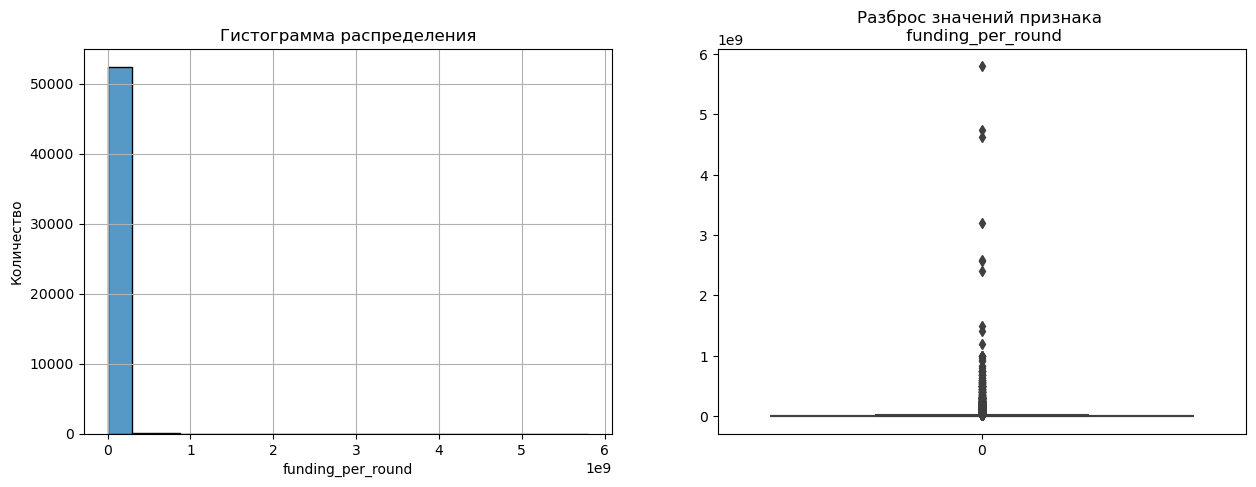

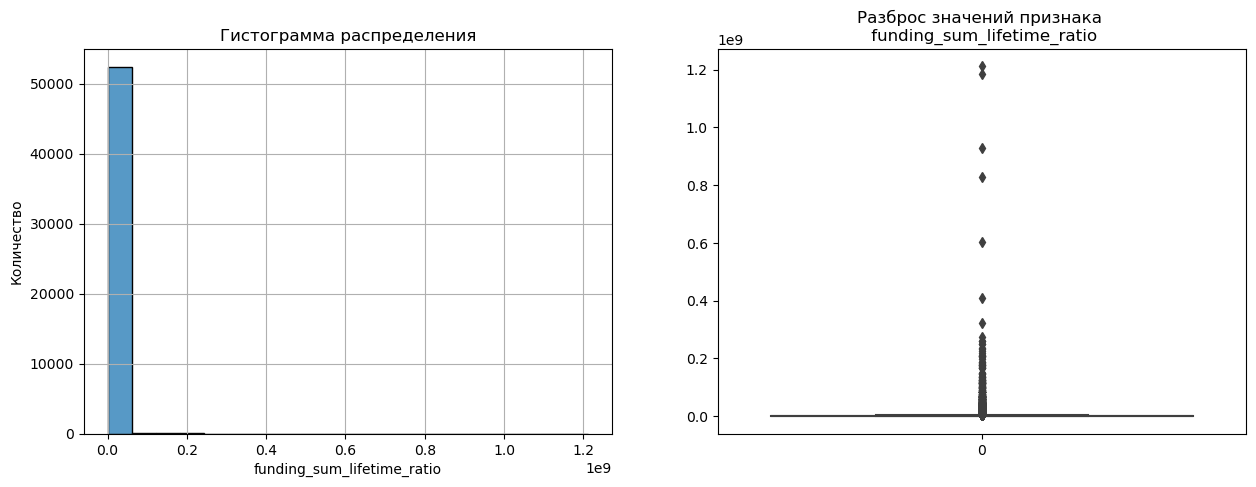

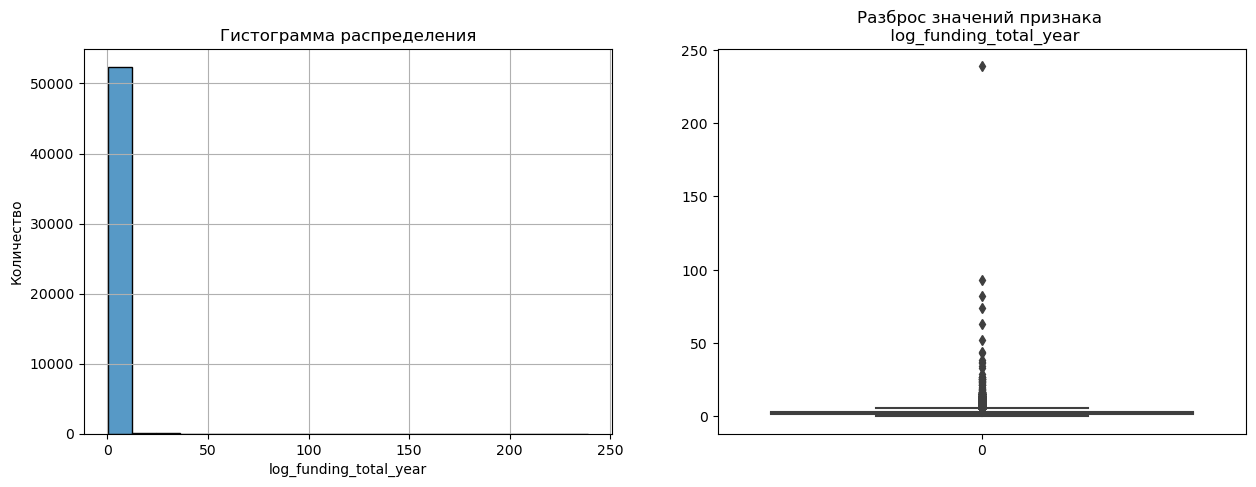

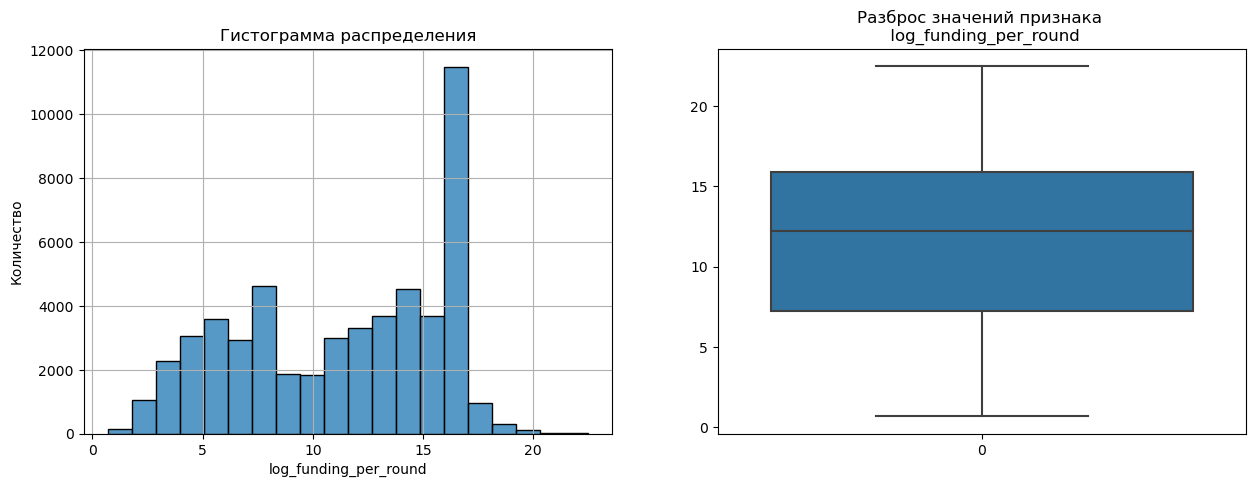

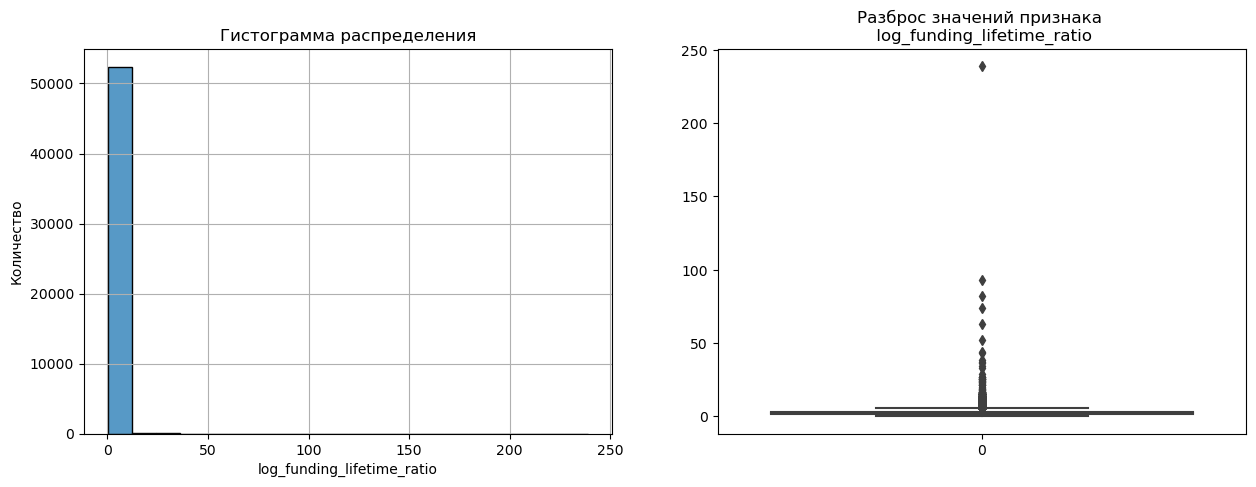

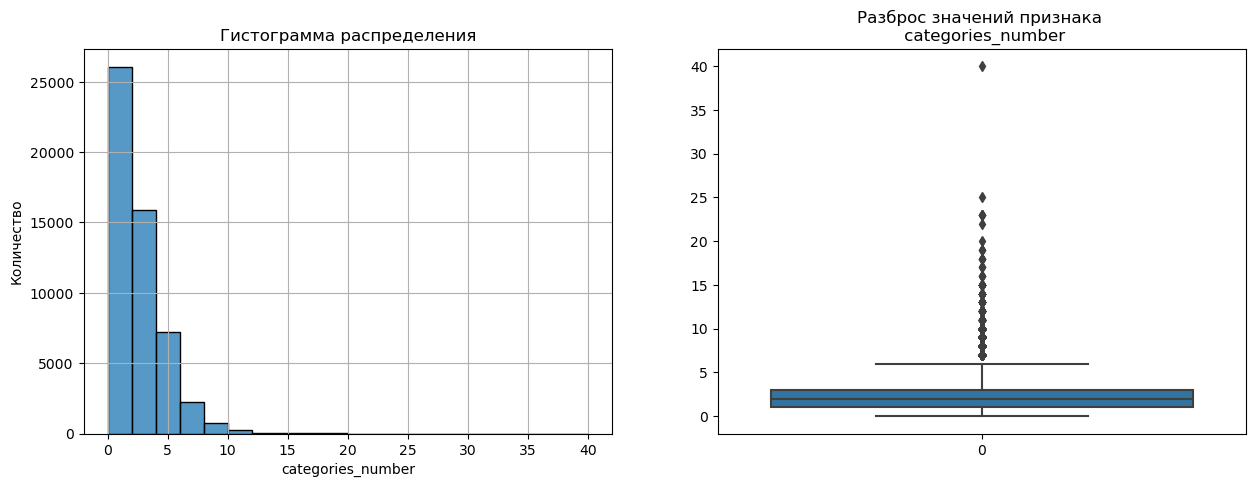

In [48]:
# Определяем список количественных признаков тренировочного датафрейма
numeric_features_train = df_train.select_dtypes(include = ['int', 'float']).columns
# Применим созданную функцию plot_hist_box к тренировочному датафрейму 
for column in numeric_features_train:
    plot_hist_box(df_train, column)

### Добавление новых признаковв тестовую выборку

In [49]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_test['log_funding_total_usd'] = np.log1p(df_test['funding_total_usd'])

In [50]:
# Конструирование признаков 

df_test['lifetime_year'] = df_test['lifetime'] / 365.25

In [51]:
df_test['funding_rounds_per_year'] = df_test['funding_rounds'] / df_test['lifetime_year']
df_test['funding_total_per_year'] = df_test['funding_total_usd'] / df_test['lifetime_year']
df_test['funding_per_round'] = df_test['funding_total_usd'] / df_test['funding_rounds']
df_test['funding_sum_lifetime_ratio'] = df_test['funding_total_usd'] / df_test['lifetime_year']

df_test['log_funding_total_year'] = df_test['log_funding_total_usd'] / df_test['lifetime_year']
df_test['log_funding_per_round'] = df_test['log_funding_total_usd'] / df_test['funding_rounds']
df_test['log_funding_lifetime_ratio'] = df_test['log_funding_total_usd'] / df_test['lifetime_year']

# Handle infinite values resulting from division by zero
df_test.replace([float('inf'), -float('inf')], 0, inplace=True)

In [52]:
# Введем признак количество категорий, где за единицу примем категорию до знака разделения '|'

df_test['categories_number'] = df_test['category_list'].apply(
                lambda x: x.count('|') + 1 if isinstance(x, str) else 0)
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,log_funding_total_usd,lifetime_year,funding_rounds_per_year,funding_total_per_year,funding_per_round,funding_sum_lifetime_ratio,log_funding_total_year,log_funding_per_round,log_funding_lifetime_ratio,categories_number
0,Crystalsol,Clean Technology,2819200.0,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,...,14.851964,9.585216,0.104327,2.941196e+05,2819200.0,2.941196e+05,1.549466,14.851964,1.549466,1
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,NaN,7.438741,0.134431,NaN,NaN,NaN,NaN,NaN,NaN,1
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,12.967481,3.545517,0.564093,1.207883e+05,214128.5,1.207883e+05,3.657430,6.483741,3.657430,1
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,17.362250,12.999316,0.307709,2.669371e+06,8675000.0,2.669371e+06,1.335628,4.340563,1.335628,3
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,15.326233,16.999316,0.058826,2.664813e+05,4530000.0,2.664813e+05,0.901579,15.326233,0.901579,1


In [53]:
# Преобразуем признак funding_total_usd в логарифмический масштаб

df_test['log_funding_total_usd'] = np.log1p(df_test['funding_total_usd'])

In [54]:
# Добавление столбцов с отдельными 5 категорями
# Применяем функцию к столбцу и создаем новый DataFrame
new_columns_test = df_test['category_list'].apply(split_and_pad).tolist()
new_df_test = pd.DataFrame(new_columns_test, columns=[f'Field_{i+1}' for i in range(5)])

# Добавляем новые столбцы в исходный DataFrame
df_test_concat = pd.concat([df_test, new_df_test], axis=1)
df_test['category_list'].isna().sum()
df_test_concat.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,funding_sum_lifetime_ratio,log_funding_total_year,log_funding_per_round,log_funding_lifetime_ratio,categories_number,Field_1,Field_2,Field_3,Field_4,Field_5
0,Crystalsol,Clean Technology,2819200.0,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,...,2.941196e+05,1.549466,14.851964,1.549466,1,Clean Technology,None,None,None,None
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,NaN,NaN,NaN,NaN,1,Hospitality,None,None,None,None
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,1.207883e+05,3.657430,6.483741,3.657430,1,Finance,None,None,None,None
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,2.669371e+06,1.335628,4.340563,1.335628,3,Software,Video,Video Streaming,None,None
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,2.664813e+05,0.901579,15.326233,0.901579,1,Software,None,None,None,None


In [55]:
# Категории в полученных столбцах заменим ключами (областями деятельности) 
# Поскольку возможны дубликаты в списках, оставим первую встечающуюся категорию, а дубликаты сотрем
reverse_dict = {}
for k, values in dict_sum.items():
    for v in values:
        if v not in reverse_dict:
            reverse_dict[v] = k

# Заменим категории на ключи словаря
columns_to_replace = ['Field_1', 'Field_2', 'Field_3', 'Field_4', 'Field_5']
df_test = df_test_concat

# Применим функцию обработки значений None и отсутствующих строк (в качестве защиты)
df_test[columns_to_replace] = df_test[columns_to_replace].applymap(
                                        lambda x: reverse_dict.get(x, "unknown") if x is not None else 'empty')
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,...,funding_sum_lifetime_ratio,log_funding_total_year,log_funding_per_round,log_funding_lifetime_ratio,categories_number,Field_1,Field_2,Field_3,Field_4,Field_5
0,Crystalsol,Clean Technology,2819200.0,unknown,unknown,unknown,unknown,1,2009-07-01,2009-07-01,...,2.941196e+05,1.549466,14.851964,1.549466,1,Energy and Clean Technologies,empty,empty,empty,empty
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,...,NaN,NaN,NaN,NaN,1,Tourism and Hospitality,empty,empty,empty,empty
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,...,1.207883e+05,3.657430,6.483741,3.657430,1,Financial and Banking Services,empty,empty,empty,empty
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,...,2.669371e+06,1.335628,4.340563,1.335628,3,Information Technology and Cybersecurity,"Entertainment, Media, and Advertising","Entertainment, Media, and Advertising",empty,empty
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,...,2.664813e+05,0.901579,15.326233,0.901579,1,Information Technology and Cybersecurity,empty,empty,empty,empty


### Изучим количественные признаки  в тестовой  выборке

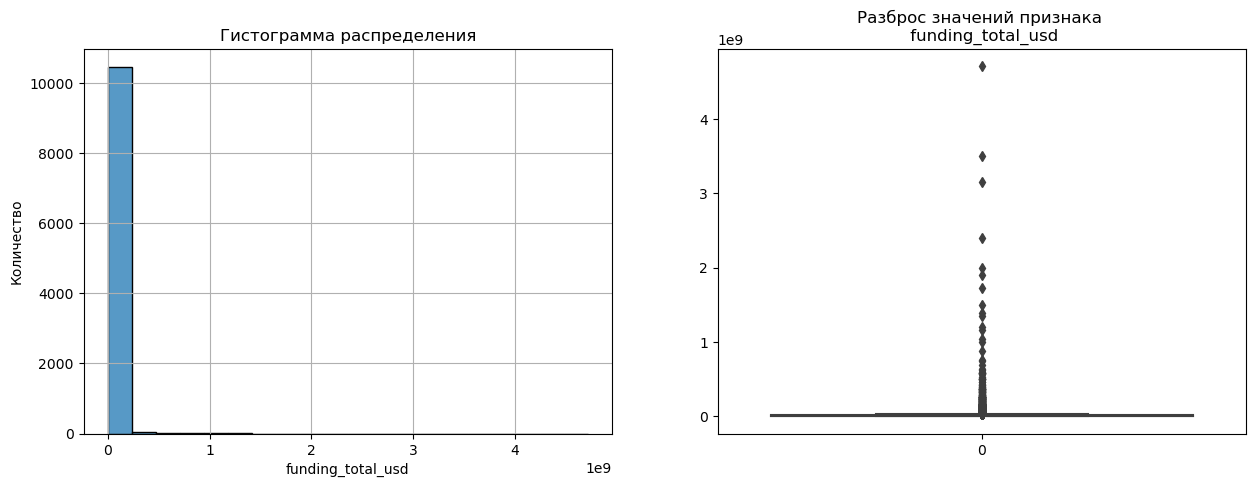

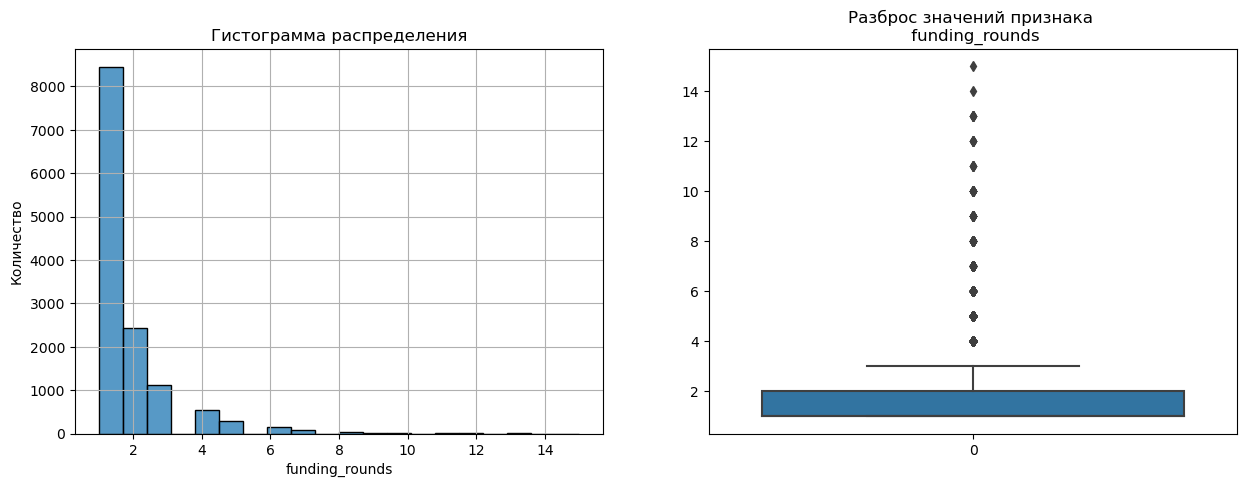

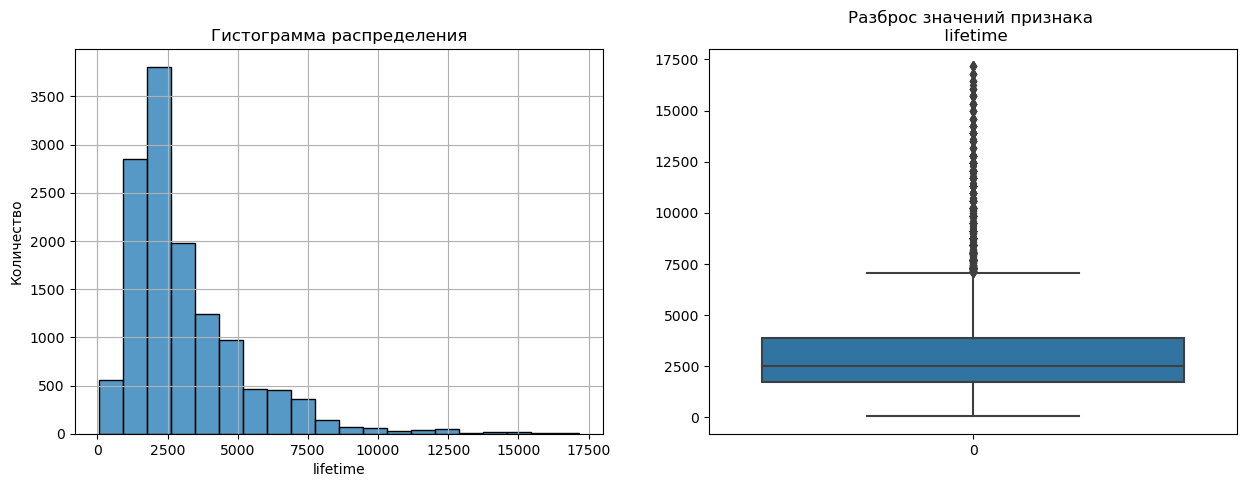

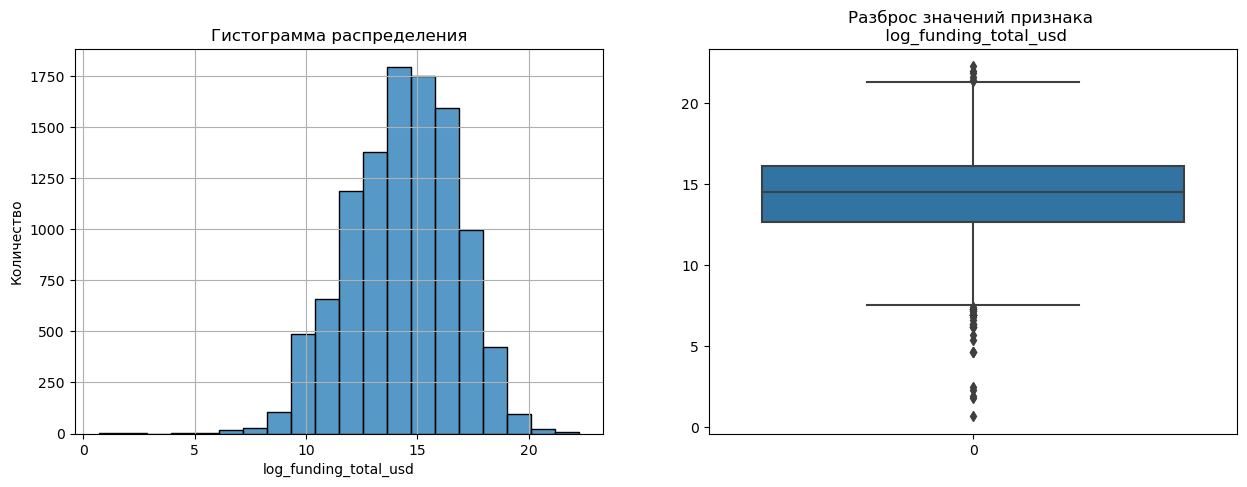

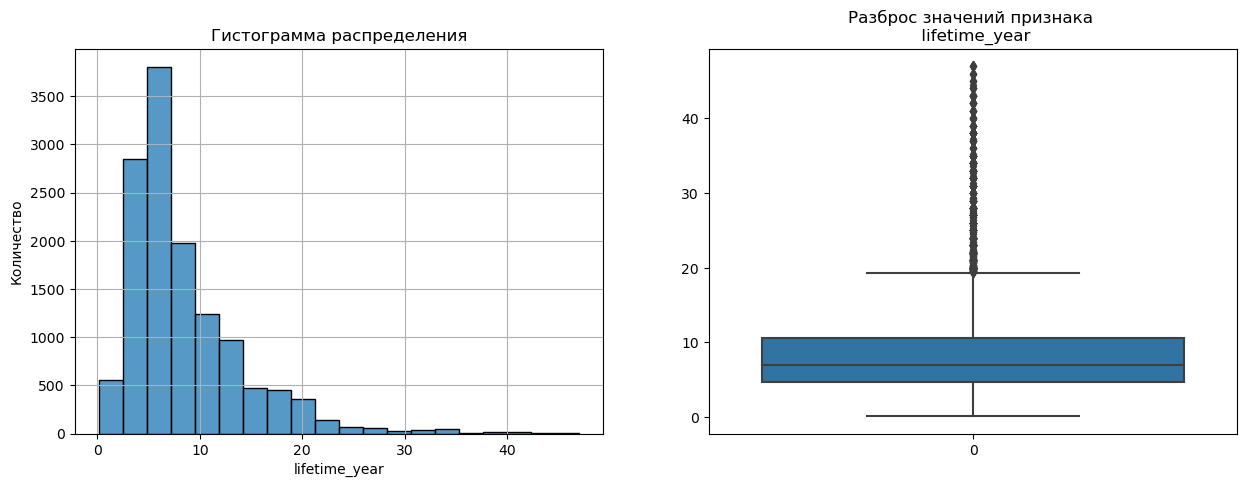

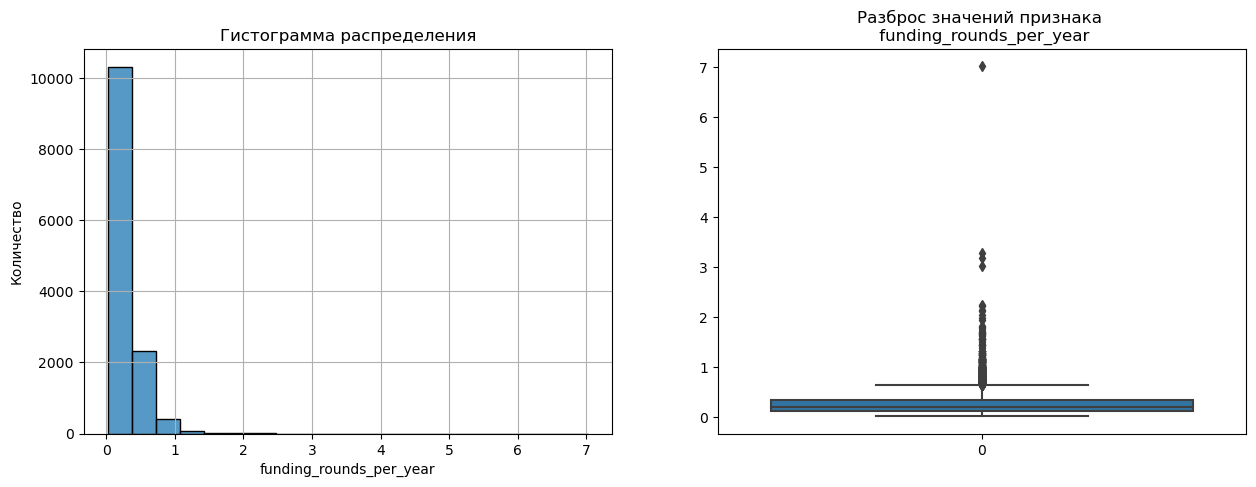

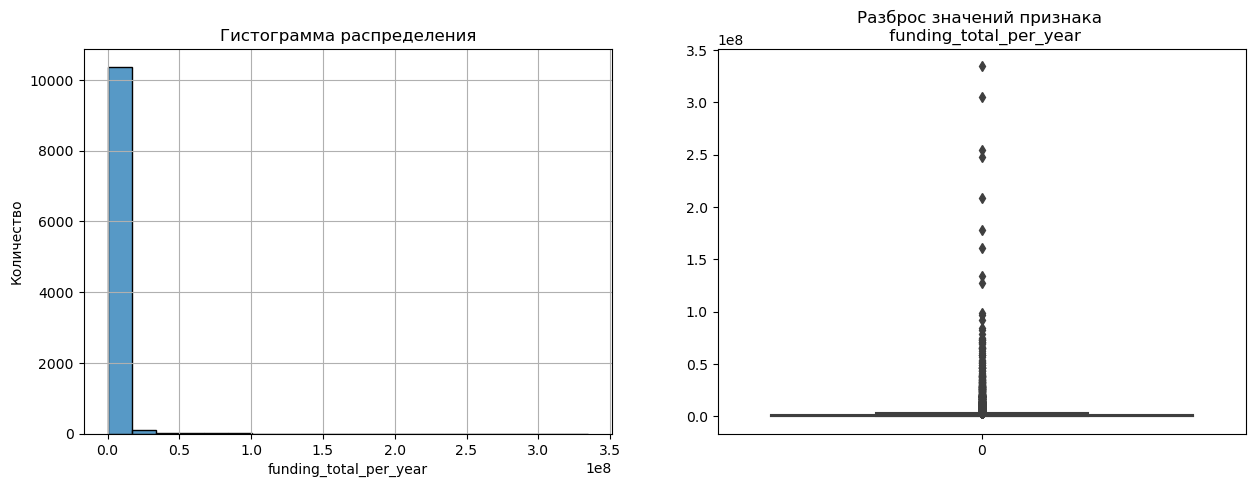

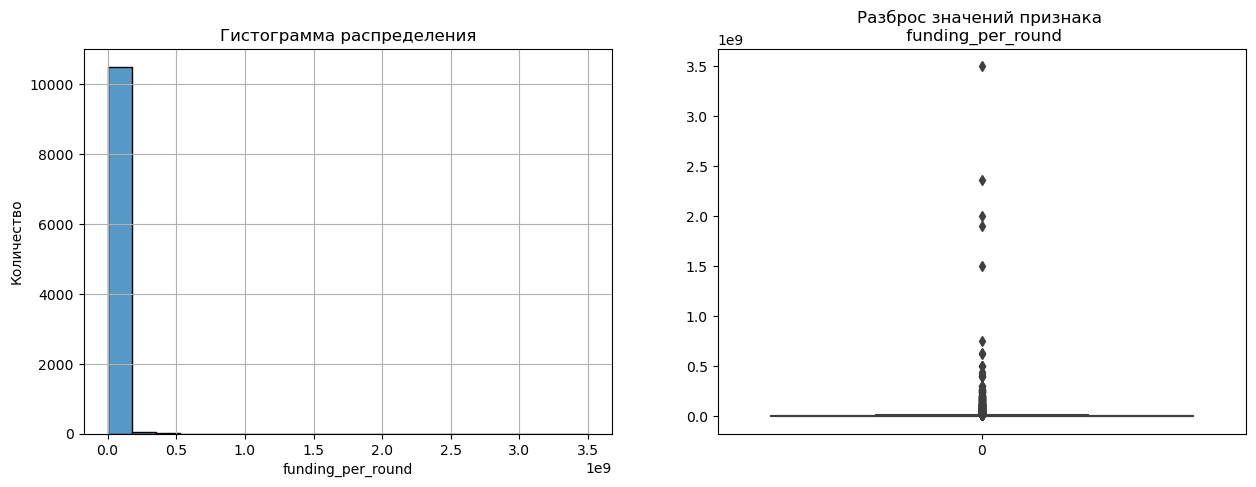

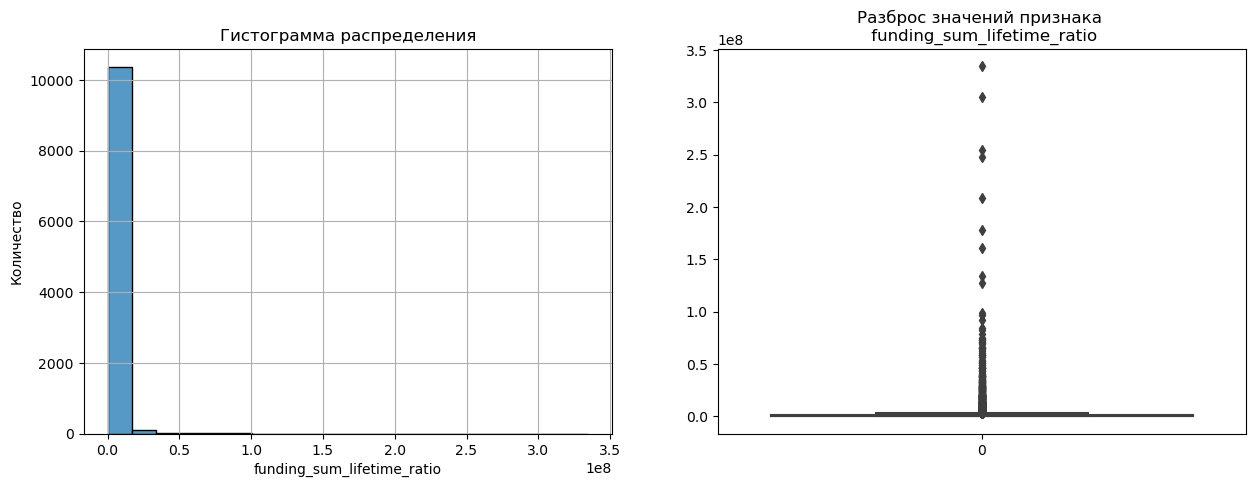

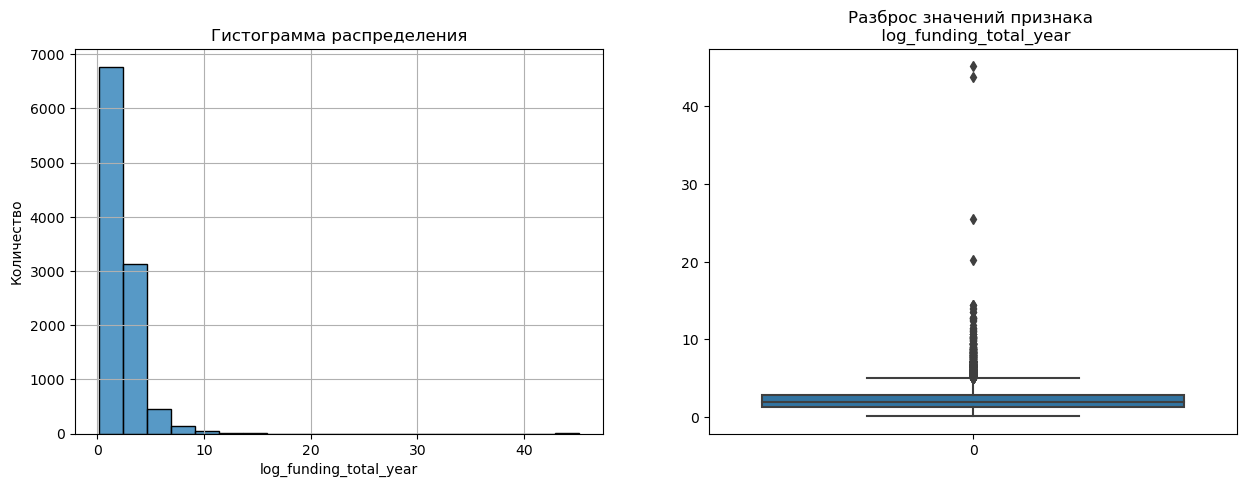

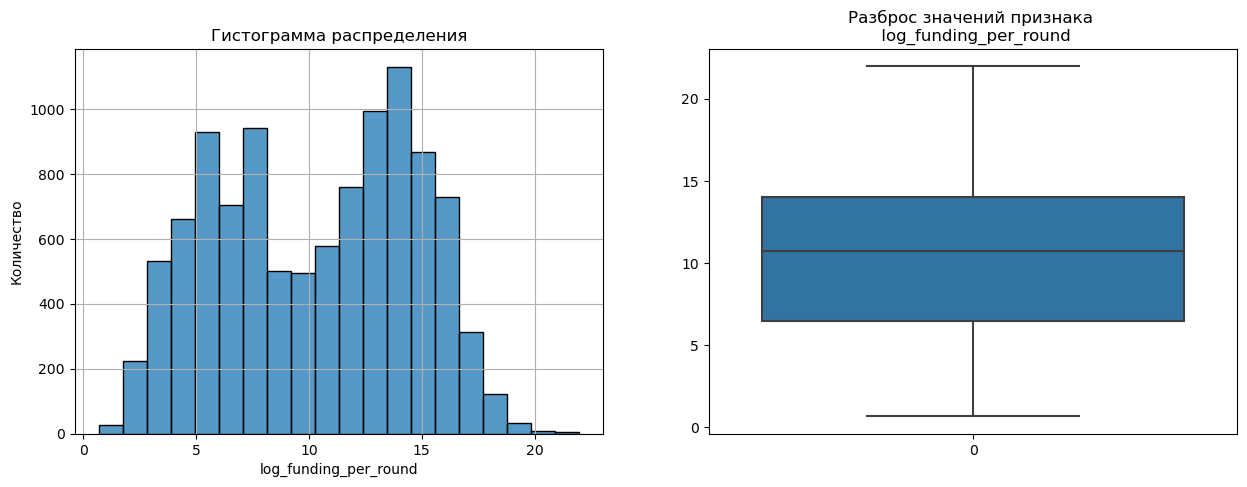

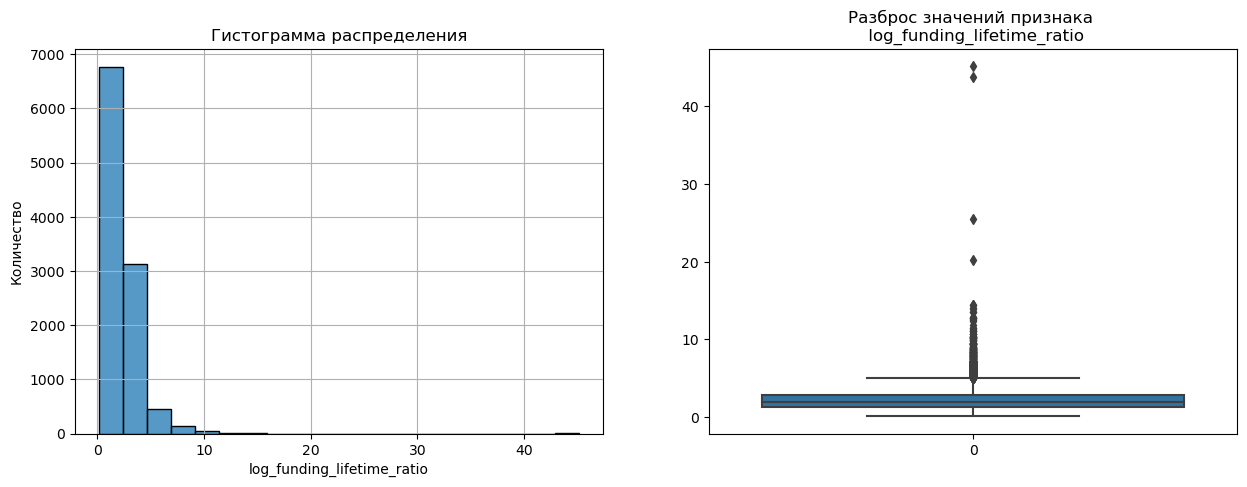

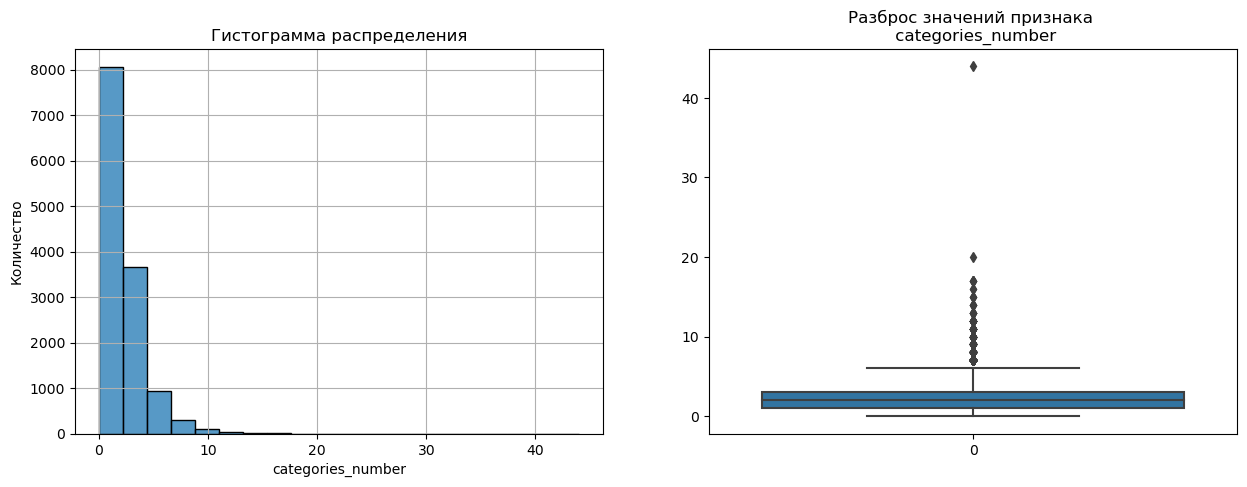

In [56]:
# Определяем список количественных признаков тренировочного датафрейма
numeric_features_test = df_test.select_dtypes(include = ['int', 'float']).columns
# Применим созданную функцию plot_hist_box к тренировочному датафрейму 
for column in numeric_features_test:
    plot_hist_box(df_test, column)

### Сравним распределение количественных признаков в тренировочной выборке в зависимости от статуса компании

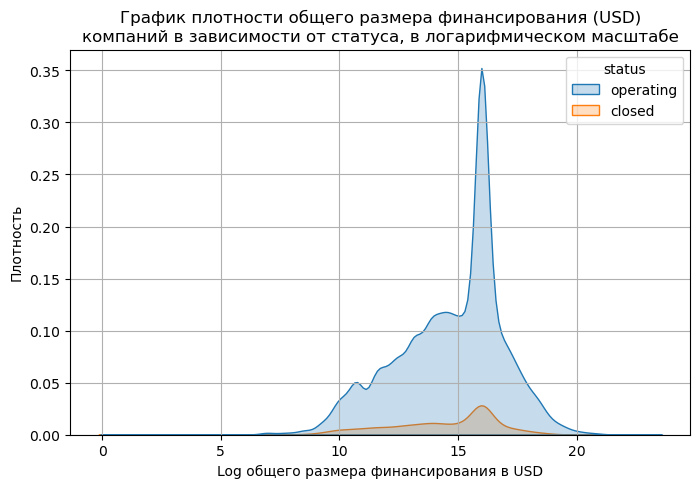

In [57]:
plt.figure(figsize=(8, 5))

# Признак log_funding_total_usd используем в логарифм. масштабе
sns.kdeplot(data=df_train, x=np.log1p(df_train['funding_total_usd']),
            hue='status', fill=True)
plt.title('График плотности общего размера финансирования (USD)\n'
          'компаний в зависимости от статуса, в логарифмическом масштабе')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.grid()

plt.show()

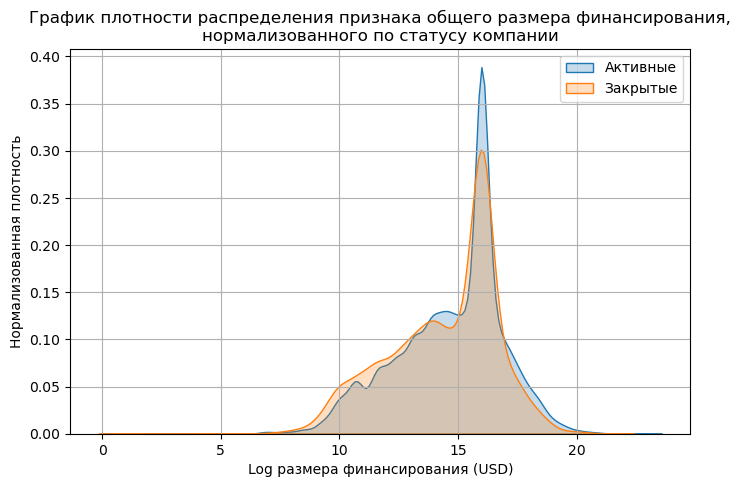

In [58]:
# Построим график плотности распределения признака log_funding_total_usd, но уже нормализованный по признаку status
# Нормализуем данные по признаку status
status_counts = df_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_train[df_train['status'] == 'operating'],
    x=np.log1p(df_train[df_train['status'] == 'operating']['funding_total_usd']),
    label='Активные',
    weights=[operating_weight] * len(df_train[df_train['status'] == 'operating']),
    fill=True
)
sns.kdeplot(
    data=df_train[df_train['status'] == 'closed'],
    x=np.log1p(df_train[df_train['status'] == 'closed']['funding_total_usd']),
    label='Закрытые',
    weights=[closed_weight] * len(df_train[df_train['status'] == 'closed']),
    fill=True
)

plt.title('График плотности распределения признака общего размера финансирования,\n'
          'нормализованного по статусу компании')
plt.xlabel('Log размера финансирования (USD)')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

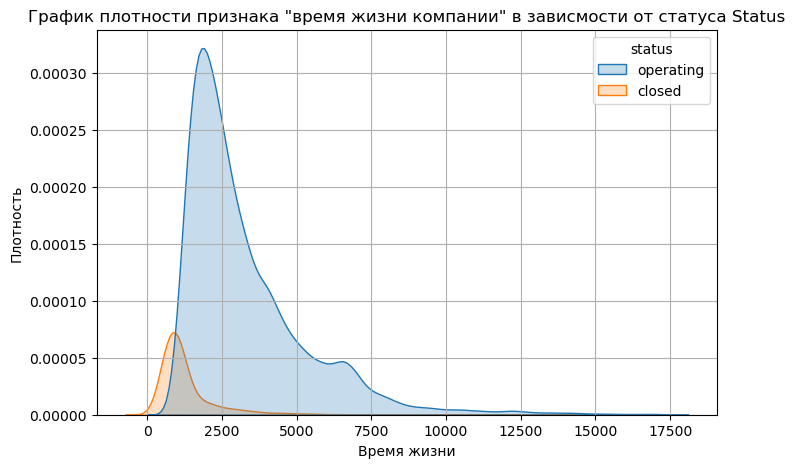

In [59]:
# Построим график плотности распределения признака lifetime, используя seaborn
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_train, x='lifetime', hue='status', fill=True)
plt.title('График плотности признака "время жизни компании" в зависмости от статуса Status')
plt.xlabel('Время жизни')
plt.ylabel('Плотность')
plt.grid()

plt.show()

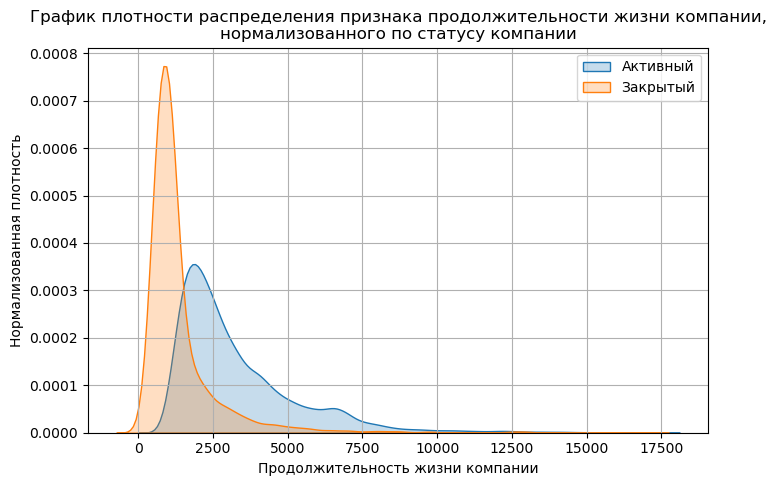

In [60]:
# Построим график плотности распределения признака lifetime, но уже нормализованный по признаку status
# Нормализуем данные по признаку status
status_counts = df_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_train[df_train['status'] == 'operating'],
    x='lifetime',
    label='Активный',
    weights=[operating_weight] * len(df_train[df_train['status'] == 'operating']),
    fill=True
)
sns.kdeplot(
    data=df_train[df_train['status'] == 'closed'],
    x='lifetime',
    label='Закрытый',
    weights=[closed_weight] * len(df_train[df_train['status'] == 'closed']),
    fill=True
)

plt.title('График плотности распределения признака продолжительности жизни компании,\n'
          'нормализованного по статусу компании')
plt.xlabel('Продолжительность жизни компании')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

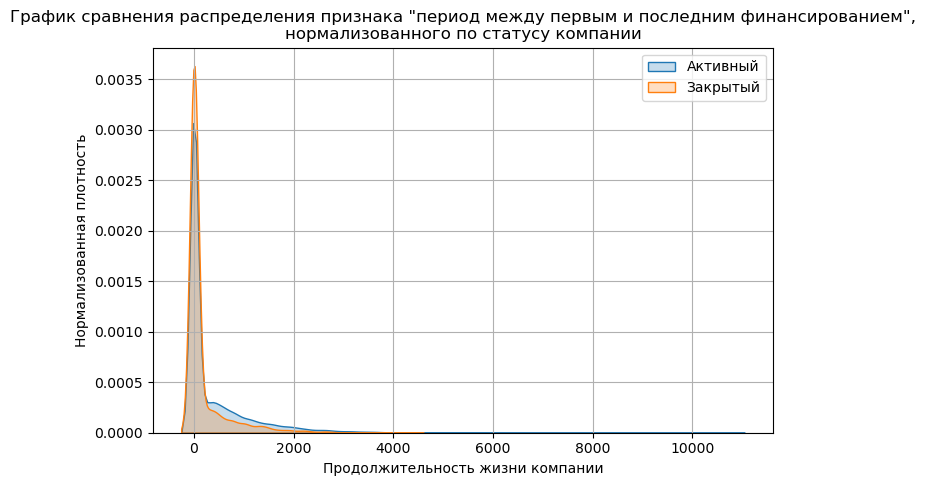

In [61]:
# Построим график плотности распределения признака funding_period, нормализованный по признаку status
# Нормализуем данные по признаку status
status_counts = df_train['status'].value_counts(normalize=True)
operating_weight = status_counts['operating']
closed_weight = status_counts['closed']

# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_train[df_train['status'] == 'operating'],
    x='funding_period',
    label='Активный',
    weights=[operating_weight] * len(df_train[df_train['status'] == 'operating']),
    fill=True
)
sns.kdeplot(
    data=df_train[df_train['status'] == 'closed'],
    x='funding_period',
    label='Закрытый',
    weights=[closed_weight] * len(df_train[df_train['status'] == 'closed']),
    fill=True
)

plt.title('График сравнения распределения признака "период между первым и последним финансированием",\n'
          'нормализованного по статусу компании')
plt.xlabel('Продолжительность жизни компании')
plt.ylabel('Нормализованная плотность')
plt.legend()
plt.grid()

plt.show()

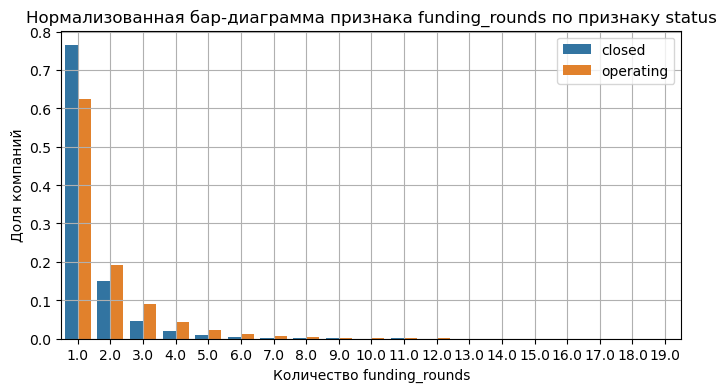

In [62]:
# Создадим функцию для построения бар диаграммы по нормализованным данным
def normalized_status_bar_chart(df, feature, target):
    # Create a DataFrame with counts of occurrences
    count_df = df.groupby([target, feature]).size().reset_index(name='counts')

    # Calculate the total counts for each status category
    total_counts = count_df.groupby(target)['counts'].transform('sum')

    # Calculate the normalized count
    count_df['normalized_count'] = count_df['counts'] / total_counts

    # Create the dodged bar chart
    plt.figure(figsize=(8, 4))
    bar_chart = sns.barplot(x=feature, y='normalized_count', hue=target, data=count_df, dodge=True)
    plt.title('Нормализованная бар-диаграмма признака {} по признаку {}'.format(feature, target))
    plt.xlabel('Количество {}'. format(feature))
    plt.ylabel('Доля компаний')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()

# Usage
normalized_status_bar_chart(df_train, 'funding_rounds', 'status')

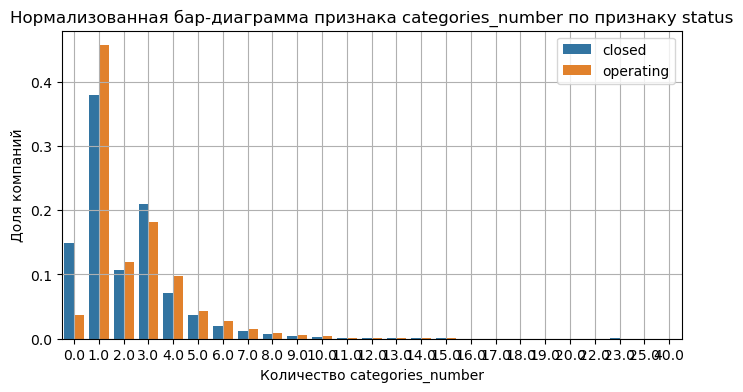

In [63]:
### Посмотрим, влияет ли на статус компании количество заявленных категорий
normalized_status_bar_chart(df_train, 'categories_number', 'status')


### Сравним тренировочный и тестовый датафреймы по количественным признакам 

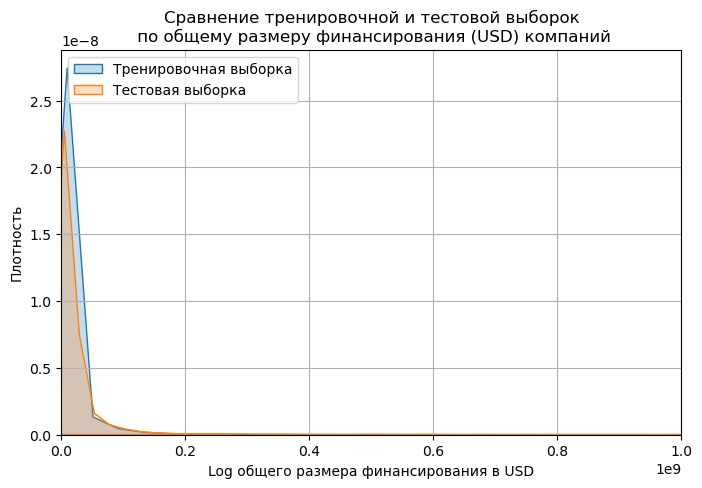

In [64]:
# Построим график плотности признака, используя seaborn для двух датафреймов
plt.figure(figsize=(8, 5))
# Сравнение выполним в логарифмическом масштабе из-за большой дисперсии признака

sns.kdeplot(data=df_train, x='funding_total_usd', 
            fill=True, label='Тренировочная выборка')
sns.kdeplot(data=df_test, x='funding_total_usd', 
            fill=True, label='Тестовая выборка')

plt.title('Сравнение тренировочной и тестовой выборок\n по общему размеру финансирования (USD) компаний')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.legend(loc='upper left')
plt.grid()
plt.xlim(0, 1e9)

plt.show()

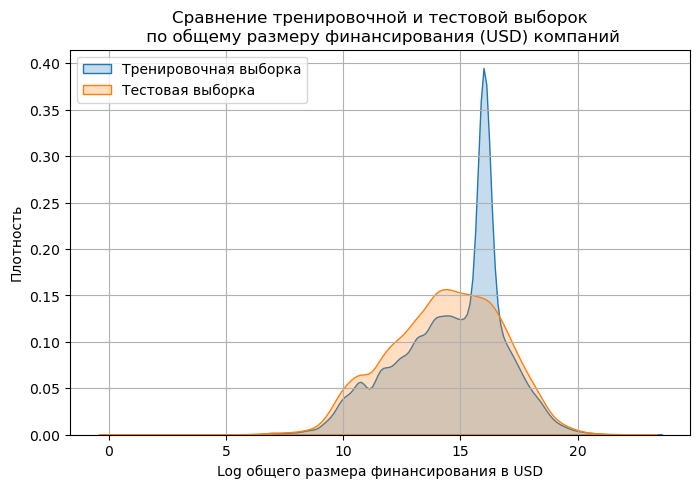

In [65]:
# Построим график плотности признака, используя seaborn для двух датафреймов
plt.figure(figsize=(8, 5))
# Сравнение выполним в логарифмическом масштабе из-за большой дисперсии признака

sns.kdeplot(data=df_train, x=np.log1p(df_train['funding_total_usd']), 
            fill=True, label='Тренировочная выборка')
sns.kdeplot(data=df_test, x=np.log1p(df_test['funding_total_usd']), 
            fill=True, label='Тестовая выборка')

plt.title('Сравнение тренировочной и тестовой выборок\n по общему размеру финансирования (USD) компаний')
plt.xlabel('Log общего размера финансирования в USD')
plt.ylabel('Плотность')
plt.legend(loc='upper left')
plt.grid()

plt.show()

Как видно из графиков, тестовая и тренировочная выборки имеют практически аналогичное распределение количественных признаков.

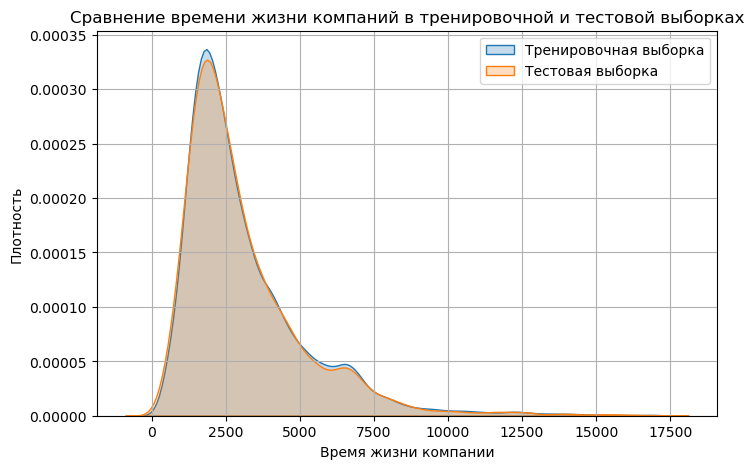

In [66]:
# Построим график плотности распределения
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_train['lifetime'], label='Тренировочная выборка', fill=True)

sns.kdeplot(data=df_test['lifetime'], label='Тестовая выборка', fill=True)

plt.title('Сравнение времени жизни компаний в тренировочной и тестовой выборках')
plt.xlabel('Время жизни компании')
plt.ylabel('Плотность')
plt.legend(loc = 'upper right')
plt.grid()

plt.show()

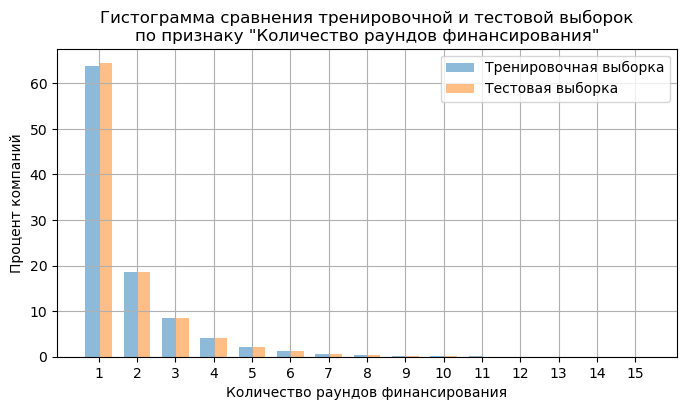

In [67]:
funding_rounds_range = range(1, 16)

# Отфильтруем датафрейм по признаку  funding_rounds 
df_train_filtered = df_train[df_train['funding_rounds'].isin(funding_rounds_range)]
df_test_filtered = df_test[df_test['funding_rounds'].isin(funding_rounds_range)]

# Вычисли количества для каждого раунда финансирования
counts_df_train = df_train_filtered['funding_rounds'].value_counts().reindex(
                                                   funding_rounds_range, fill_value=0)
counts_df_test = df_test_filtered['funding_rounds'].value_counts().reindex(funding_rounds_range, fill_value=0)
                      
# Нормализуем количество, чтобы получить процент
percentage_df_train = (counts_df_train / counts_df_train.sum()) * 100
percentage_df_test = (counts_df_test / counts_df_test.sum()) * 100

# Определим ширину бара и сдвиг
bar_width = 0.35
shift = bar_width / 2

# Определим положение каждого бара
positions_df_train = np.arange(len(funding_rounds_range)) - shift
positions_df_test = np.arange(len(funding_rounds_range)) + shift

# Построим график
plt.figure(figsize=(8, 4))
plt.bar(positions_df_train, percentage_df_train, width=bar_width, label='Тренировочная выборка', alpha=0.5)
plt.bar(positions_df_test, percentage_df_test, width=bar_width, label='Тестовая выборка', alpha=0.5)

plt.title('Гистограмма сравнения тренировочной и тестовой выборок\n'
          'по признаку "Количество раундов финансирования"')
plt.xlabel('Количество раундов финансирования')
plt.ylabel('Процент компаний')
plt.xticks(np.arange(len(funding_rounds_range)), funding_rounds_range)
plt.legend()
plt.grid()

plt.show()

### Посмотрим на корреляцию признаков в тренировочной выборке

In [68]:
df_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'lifetime',
       'lifetime_year', 'log_funding_total_usd', 'funding_period',
       'funding_rounds_per_year', 'funding_total_per_year',
       'funding_per_round', 'funding_sum_lifetime_ratio',
       'log_funding_total_year', 'log_funding_per_round',
       'log_funding_lifetime_ratio', 'categories_number', 'Field_1', 'Field_2',
       'Field_3', 'Field_4', 'Field_5'],
      dtype='object')

In [69]:
# Задаем списки количественных и категориальных признаков

num_columns = [
            'log_funding_total_usd',
#            'funding_total_usd',
#            'funding_rounds', 
#            'lifetime_year', 
            'lifetime', 
#            'categories_number',
            'funding_rounds_per_year',
#            'funding_total_per_year',
            'funding_per_round',
#            'funding_lifetime_ratio',
    
            'log_funding_total_year',
#            'log_funding_total_per_round',
            'log_funding_lifetime_ratio'
            ]

ohe_columns = [
#            'country_code',
#            'state_code', 
#            'region',
#            'city', 
#            'Field_1', 
#            'Field_2', 
#            'Field_3', 
#            'Field_4', 
#            'Field_5'
            ]

In [70]:
column_processed = num_columns.copy()
column_processed.extend(ohe_columns)

interval columns not set, guessing: ['log_funding_total_usd', 'lifetime', 'funding_rounds_per_year', 'funding_per_round', 'log_funding_total_year', 'log_funding_lifetime_ratio']


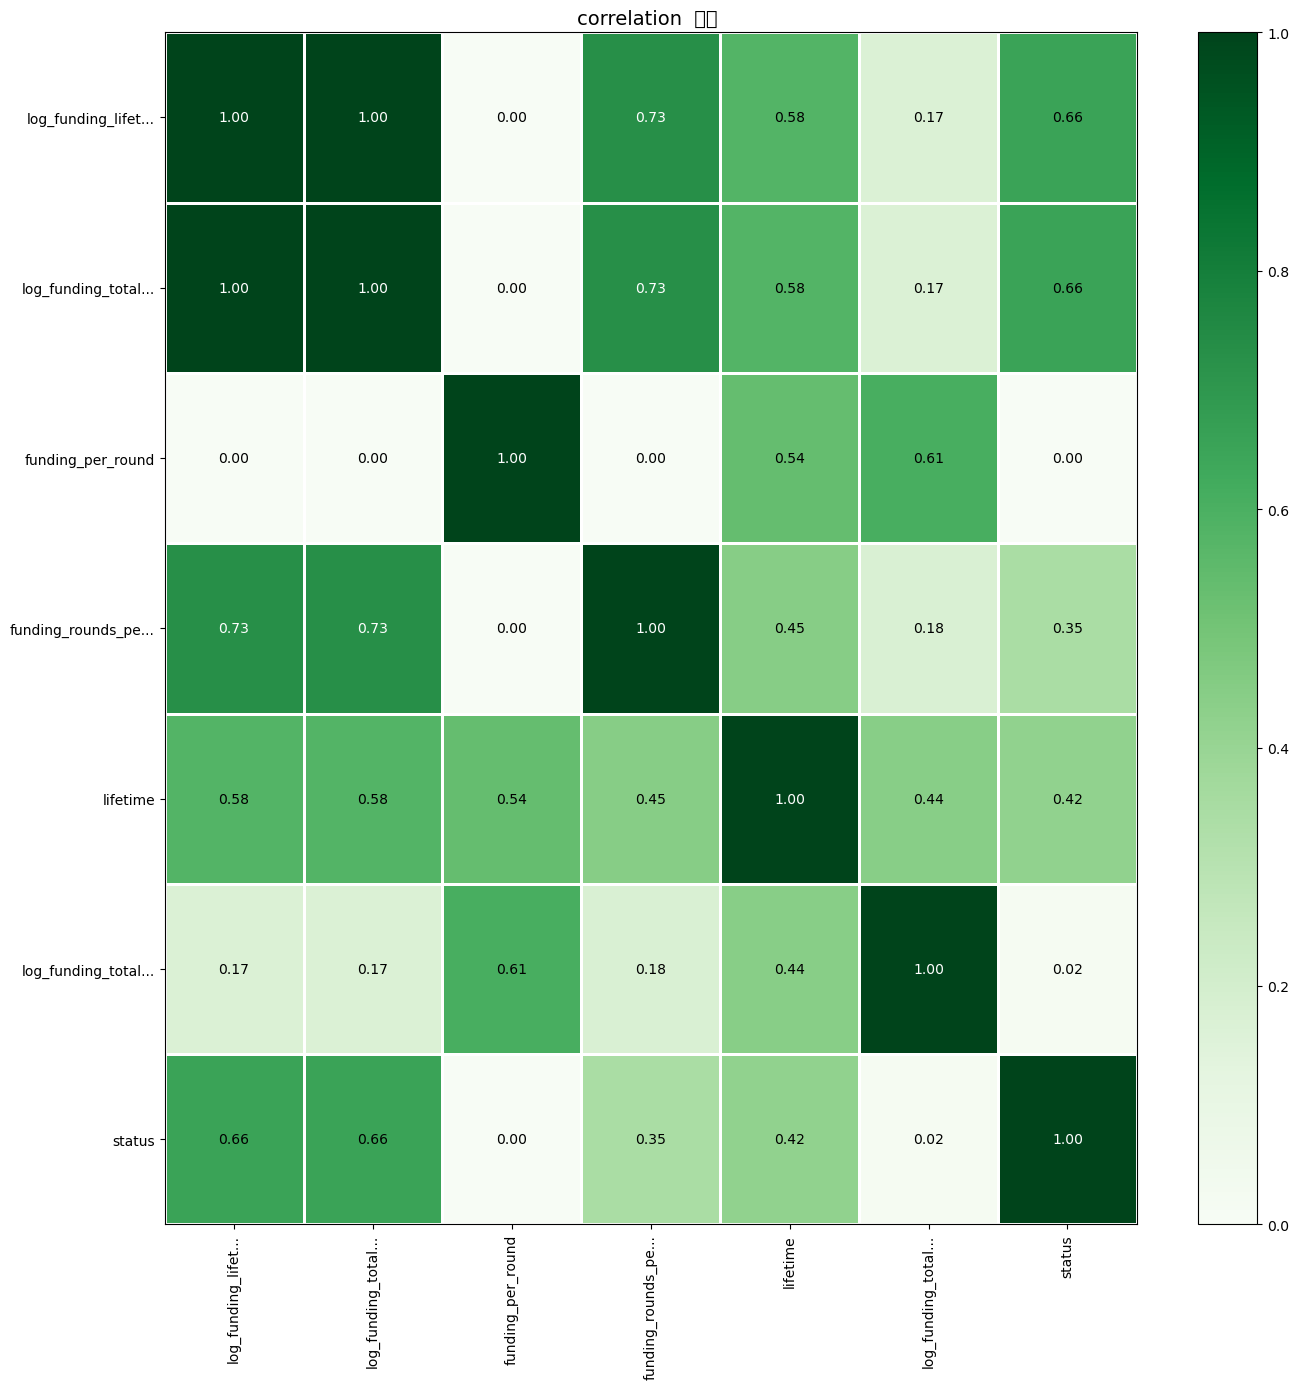

In [71]:
corr_list = ['status']
corr_list.extend(column_processed)
phik_overview = df_train[corr_list].sample(1000).phik_matrix() 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'correlation  𝜙𝐾 ', fontsize_factor=1, figsize=(14,14)) 

plt.tight_layout()

### Посмотрим на корреляцию признаков в тестовой выборке

interval columns not set, guessing: ['log_funding_total_usd', 'lifetime', 'funding_rounds_per_year', 'funding_per_round', 'log_funding_total_year', 'log_funding_lifetime_ratio']


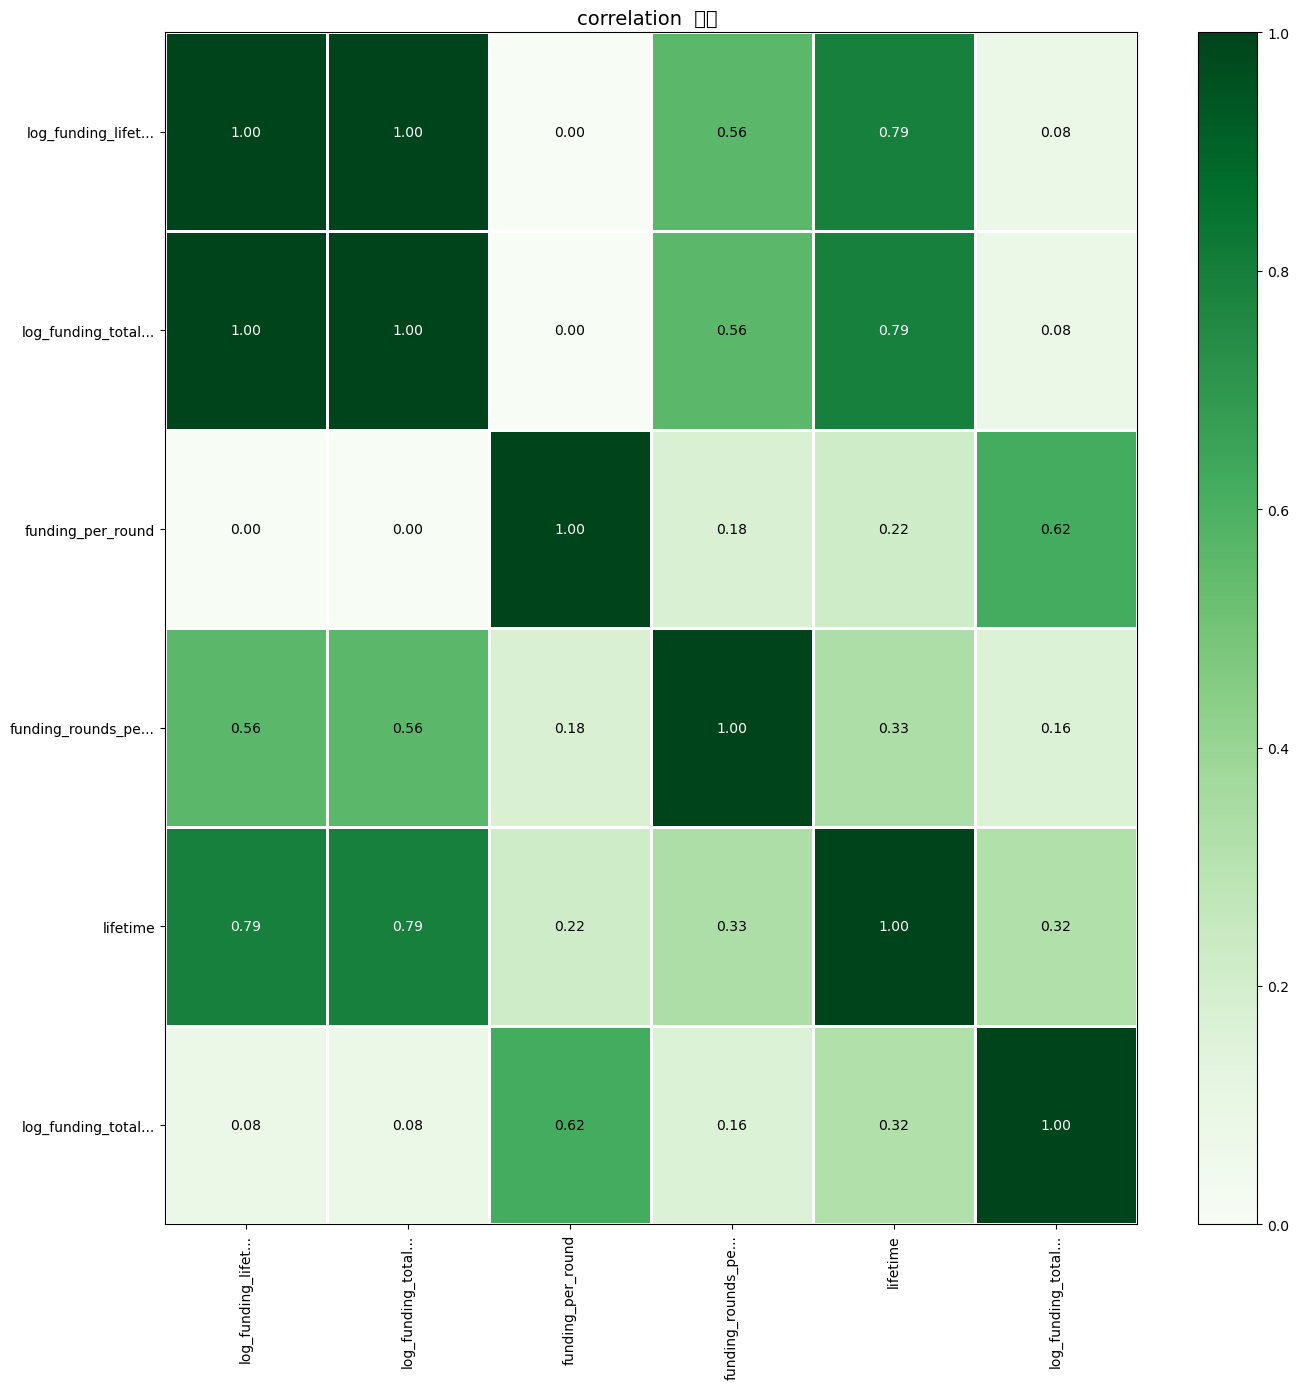

In [72]:
phik_overview = df_test[column_processed].sample(1000).phik_matrix() 
plot_correlation_matrix(
    phik_overview.values, x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Greens', 
    title=r'correlation  𝜙𝐾 ', fontsize_factor=1, figsize=(14,14)) 

plt.tight_layout()

### Создадим пайплан для подбора гиперпараметров

In [73]:
# Задаем тренировочную выборку

X = df_train[column_processed]
y = df_train['status'].map({'closed': 1, 'operating': 0})

# Делим тренировочную выборку на две для тренировки и тестирования
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.67, random_state=RANDOM_STATE)

# Проверка наличия пропущенных значений в столбце 'status'
missing_values = df_train['status'].isnull().sum()
print(f"Количество пропущенных значений в столбце 'status': {missing_values}")

Количество пропущенных значений в столбце 'status': 0


In [74]:
# Задаем списки количественных и категориальных признаков

#num_columns = ['funding_total_usd_log', 'funding_rounds', 'lifetime', 'categories_number']
#ohe_columns = ['region', 'Field_1', 'Field_2', 'Field_3', 'Field_4', 'Field_5']

In [75]:
# Создадим пайплайн для подготовки входных данных
# Паплайн для заполнения пропусков и обработки категориальных признаков 

ohe_pipe = Pipeline([ 
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop = 'first', categories = 'auto',
                          handle_unknown = 'ignore', sparse_output = False))
    ])

# Паплайн для обработки числовых признаков: заполнение пропусков и масштабирование для количественных признаков 

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())  
    ])

# Создадим ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer([
     ('ohe', ohe_pipe, ohe_columns),
     ('num', num_pipe, num_columns)
],
remainder='drop' )

In [81]:
# Создадим словарь гиперпараметров для каждой используемой модели
param_grid = {
    
    'Logistic Regression': {
        'models__max_iter': [1000],
        'models__C': [1.0, 10],
        'models__solver': ['liblinear'],
        'models__penalty': ['l2', 'l1'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    'RidgeClassifier': {
        'models__alpha': [0.1, 1.0, 10.0],
        'models__max_iter': [100, 1000],
        'models__solver': ['auto', 'cholesky', 'saga'],
        'models__preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    'RandomForestClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()
#                                      MinMaxScaler(), 
                                     ]
    },
    'DecisionTreeClassifier': {
        'models__max_depth': [5, 10, 15],
        'models__min_samples_split': [2, 4, 6],
        'models__min_samples_leaf': [2, 4, 6],
        'models__class_weight': ['balanced'],
        'preprocessor__num__scaler': [StandardScaler(), RobustScaler()
#                                      MinMaxScaler(), 
                                     ]
    },
    'Boosting': {
        'models__min_samples_leaf': [2, 5],
        'models__min_samples_split': [2, 4],
        'models__max_depth': [10],
        'preprocessor__num__scaler': [RobustScaler()]
    }

}

# Создадим словарь используемых моделей
models = {

    "Logistic Regression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Boosting": GradientBoostingClassifier(),
    "RidgeClassifier": RidgeClassifier()
}

# Создадим пустой словарь пайплайнов моделей 
model_pipelines = {}

# Для каждой модели создается экземпляр ImbPipeline
#for name, model in models.items():
#    model_pipelines[name] = ImbPipeline(steps=[('preprocessor', data_preprocessor), 
#                                               ('undersampler', RandomUnderSampler(random_state=42)),
#                                               ('models', model)])

for name, model in models.items():
    model_pipelines[name] = ImbPipeline(steps=[('preprocessor', data_preprocessor), 
                                               ('smote', SMOTE()),
                                               ('models', model)])



In [82]:
def select_model(name):
    '''В этой функции вычисляем оптимальные гиперпараметры для модели name
    Функция возвращает:
    ''' 
     
    search = RandomizedSearchCV(model_pipelines[name], param_grid[name], cv=5, scoring='f1', n_jobs=-1)
    search.fit(X_train, y_train)
    
    cv_scores = cross_val_score(search, X_train, y_train, cv=5, scoring='f1')

#    y_pred = search.best_estimator_.predict(X_validation)

    # Перед вычислением F1-меры убедитесь, что y_test и y_pred содержат метки классов
#    f1 = round(f1_score(y_validation, y_pred), 3)

#    print(f'Лучшее значение F1 для {name}: {round(search.best_score_, 3)}')

    # Предсказание вероятностей
    y_probs = search.best_estimator_.predict_proba(X_validation)[:, 1]

    # Вычисление precision-recall кривой
    precision, recall, thresholds = precision_recall_curve(y_validation, y_probs)

    # Нахождение лучшего порога для F1-меры
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Предсказание с использованием лучшего порога
    y_pred = (y_probs >= best_threshold).astype(int)

    # Вычисление F1-меры
    f1 = round(f1_score(y_validation, y_pred), 3)

#    print(f'Лучшее значение F1 для {name}: {round(search.best_score_, 3)}')
#    print(f'Лучший порог: {best_threshold}')
#    print(f'F1-мера: {f1}')


    my_tuple = (search.best_params_, round(search.best_score_, 3), round(cv_scores.mean(), 3),
               round(cv_scores.std(), 2), round(best_threshold, 3), f1) 
    
    return my_tuple, cv_scores, search.best_estimator_

In [83]:
model_name = 'RidgeClassifier'

In [84]:
my_output, my_cv_scores, my_best_estimator = select_model(model_name)

ValueError: Invalid parameter 'preprocessor' for estimator RidgeClassifier(). Valid parameters are: ['alpha', 'class_weight', 'copy_X', 'fit_intercept', 'max_iter', 'positive', 'random_state', 'solver', 'tol'].

In [ ]:
print(my_cv_scores)

In [ ]:
print(f'Лучшие параметры для {model_name}: {my_output[0]}')
print()
print(f'Лучшее значение F1 для {model_name}: {my_output[1]}')
print()
print(f'Среднее значение тренировочного F1 = {my_output[2]}')
print(f'Mean STD = +- {my_output[3]}')
print()
print(f'Лучший порог: {my_output[4]}')
print()
print(f'Значение F1 для лучшего порога: {my_output[5]}')

In [ ]:
# Создадим функцию для визуализации важности признаков 
""" Функция для визуализации важности признаков
Принимает значения:
словарь best_estimators (ключ - имя модели,
значения - пайплайн для тренированной модели с оптимальными параметрами),
X_train, X_test (тренировочная и тестовая выборки), y_test (целевой признак),
scorer - метрика оценки точности предсказания модели.
Выдает графики:
распределение признаков по важности """

def feature_importance(best_estimator, X_train, X_test, y_test): 
#    for name, best_estimator in best_estimators.items():
    feature_names = X_train.columns
    perm_importance = permutation_importance(best_estimator, X_test, y_test, scoring = 'f1') 
    feature_importances = perm_importance.importances_mean
    mean_importance = perm_importance.importances_mean.round(2)
    std_importance = perm_importance.importances_std.round(2)
    sorted_indices = mean_importance.argsort()[::-1] 
    sorted_feature_names = [feature_names[i] for i in sorted_indices] 
    sorted_mean_importance = mean_importance[sorted_indices] 
    sorted_std_importance = std_importance[sorted_indices]
    plt.figure(figsize=(8, 4))
    sns.barplot(x=sorted_mean_importance, y=sorted_feature_names, xerr=sorted_std_importance, palette='viridis') 
    plt.xlabel('Оценка важности')
    plt.ylabel('Признак')
    plt.title(f'Признаки, отсортированные по важности - Модель: {name}')
    plt.grid()
    plt.show()

In [ ]:
feature_importance(my_best_estimator, X_train, X_validation, y_validation)

### Предсказания статуса для тестовой выборки

In [ ]:
# Задаем тренировочную выборку

X_test = df_test[column_processed]


In [ ]:
model_name 

In [ ]:
probabilities = my_best_estimator.predict_proba(X_test)[:, 1]

# Применение лучшего порога для предсказания статуса закрытия
best_threshold = 0.7264427412085797
y_pred_test = (probabilities >= best_threshold).astype(int)


In [ ]:
#y_pred_test = my_best_estimator.predict(X_test)

In [ ]:
status_test = pd.Series(y_pred_test)

status_test.value_counts(normalize = True)

In [ ]:
df_test['status'] = y_pred_test 

In [ ]:
df_test['status'] = df_test['status'].replace({1: 'closed', 0: 'operating'})

In [ ]:
df_test_final = df_test[['name', 'status']]
df_test_final.head(30)

In [ ]:
df_test_final.to_csv('kaggle.csv', index=False)